In [22]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from utils import sample_PLN
import scipy.linalg as SLA
import numpy.linalg as NLA 
import torch.linalg as TLA
import scipy
from fastPLN import fastPLN
from scipy.special import factorial
import math
import seaborn as sns 
import torch 
from pandas import read_csv
import time
import scipy.integrate as integrate 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import threading
from tqdm import tqdm
#torch.set_default_dtype(torch.float64)
from sklearn.linear_model import LinearRegression
import concurrent.futures
from numba import vectorize , int32

In [23]:
device = torch.device('cpu')

In [24]:
torch.__version__

'1.8.1+cu102'

In [25]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Implementation

We first define some functions that will help implement and visualize the model. 

In [26]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be different (size (0,0) if k%p = 0)
    '''
    np.random.seed(0)
    alea = np.random.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = np.zeros((p,p))
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*toeplitz(0.7**np.arange(block_size))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*toeplitz(0.7**np.arange(last_block_size))
    return Sigma+0.1*toeplitz(0.95**np.arange(p))


def C_from_Sigma(Sigma,q): 
    ''' 
    get the best matrix of size (p,q) when Sigma is of size (p,p). i.e. reduces norm(Sigma-C@C.T)
    args : 
        Sigma : np.array of size (p,p). Should be positive definite and symmetric.
        q : int. The number of columns you want in your matrix C. 
        
    returns : C_reduct : np.array of size (p,q) that contains the q eigenvectors with largest eigenvalues. 
    '''
    w,v = SLA.eigh(Sigma) # get the eigenvaluues and eigenvectors
    C_reduct = v[:,-q:]@np.diag(np.sqrt(w[-q:])) # we take only the q best. 
    return C_reduct

In [27]:
def compare_models(dict_models,name_doss , save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model (MC_PLNPCA object where you
                      have called model.fit_IMPS()).
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the figure will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if save = True
    '''
    best_model = MC_PLNPCA(q, batch_size, true_value = True)
    best_model.init_data(Y_sampled, O, covariates)
    
    
    #get the max of all the likelihoods for a nice plot. We intialize the max with the likelihood of the 
    # model that has the true parameters (unknown in practice) 
    best_log_like = best_model.compute_mean_log_likelihood(0.0001)
    max_ = best_log_like
    for name,model in dict_models.items():
        current_max = np.max(np.array(model.log_likelihood_list))
        max_ = max(max_,current_max)
    fig,ax = plt.subplots(3,1,figsize = (15,15))
    
    
    
    ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ')
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer')
    for name,model in dict_models.items() : 
        

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_title('MSE Sigma')
        
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        

        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        
        ax[2].plot(abscisse, np.array(model.log_likelihood_list)-max_, label = name )
        ax[2].legend()
        ax[2].set_title('log_likelihood')
        ax[2].set_ylabel('log_likelihood')
        ax[2].set_yscale('symlog')
    
    ax[2].axhline(np.array(best_log_like)-max_, c = 'red', label = 'best likelihood')
    plt.suptitle(name_doss)
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [28]:
def find_best_lr(optimizer,N_iter, acc, lrs, q, batch_size, average):
    '''
    function that is supposed to find the best lr within a grid of lr (lrs) for 
    an optimizer to fit the MC_PLNPCA method. the metric used
    to discriminate each lr is the log likelihood. We parallelized the code to go faster. 
    
    args: otpimizer : should be an object of torch.optim., for example torch.optim.Rprop. 
    
        N_iter : int. The number of iterations you want to do when running the .fit_IMPS method.
    
        acc : float positive. the accuracy you want when running the .fit_IMPS method. 
        
        lrs : list. the grid of lr.
        
        q : the dimension q you want for the model. should be small.  
        
        batch_size : int. The batch_size you want  when running the .fit_IMPS method.
        
        average : int. the average argument for the model. 
        
        var_beta : positive float. the variance you want for the importance law for the integral that determines the gradient
                  of beta. 
                  
        var_C : positive float. The variance you want for the importance law for the integral
                that determines the gradient of C. 
        
        
    returns : the best lr according to the metric
    '''
    #initiate some lists. 
    metrics = list()
    models = list()
    ts = list()
    # launch the models with the right lr. 
    for lr in lrs: 
        model = MC_PLNPCA(q,batch_size, average = average, is_perfect_mean= True,true_value = False)
        t = threading.Thread(target =model.fit_IMPS,
                            args = [Y_sampled, O,covariates, N_iter          ,acc, lr     , optimizer] )
        #t =threading.Thread(target = model.fit_torch,
        #      args = [Y_sampled, O,covariates, N_iter          ,acc, lr     , optimizer] )
        t.start()
        ts.append(t)
        models.append(model)
        
    # join each threading. 
    for t in ts: 
        t.join()
    # get the metrics for each model. 
    for i, model in enumerate(models) :
        metrics.append(np.mean(np.array(model.log_likelihood_list)))
    metrics = np.nan_to_num(np.array(metrics),-100000)
    argmax = np.argmax(metrics)#argmax of the metrics 
    best_lr = lrs[argmax]
    return best_lr, dict(zip(lrs,models)), models[argmax]  #the best lr, the dict in case 
                                                           # we need it to comopare, and the best model. 






lrs = [0.01, 0.02,0.03, 0.1,0.2,0.3,0.5,1.]#,1.2,1.5,2]
#vars_ = [0.01,0.1,0.5,1,1.5,2,4,10]
#%time best_var_beta, dict_vars_beta, best_var_beta_model = find_best_var_beta(torch.optim.Adamax, 30,0.001,0.05, vars_, q ,batch_size, n//2)
#%time best_var_C, dict_vars_C, best_var_C_model = find_best_var_C(torch.optim.Adamax, 30,0.001,0.04, vars_, q ,batch_size, n//2)
%time best_lr,dict_lrs,best_model = find_best_lr(torch.optim.Adagrad, 30, 0.01,lrs, q , batch_size , average = n)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]


  0%|          | 0/30 [00:00<?, ?it/s]



  0%|          | 0/30 [00:00<?, ?it/s]






  0%|          | 0/30 [00:00<?, ?it/s]





  0%|          | 0/30 [00:00<?, ?it/s]




  0%|          | 0/30 [00:01<?, ?it/s]
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/bbatardiere/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/bbatardiere/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-e82a229dc984>", line 935, in fit_IMPS
NameError: name 'vectorized_log_likelihood' is not defined
  0%|          | 0/30 [00:01<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/bbatardiere/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/bbatardiere/anaconda3/lib/python3.8/threading.py", 

CPU times: user 7.88 s, sys: 8.79 s, total: 16.7 s
Wall time: 1.47 s


/home/bbatardiere/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bbatardiere/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
compare_models(dict_lrs, '')

NameError: name 'dict_lrs' is not defined

In [ ]:
dict_optimizers = {'Adamax' : torch.optim.Adamax,
                   'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop,
                  'SGD' : torch.optim.SGD}

In [29]:
def launch_optimizers_and_lrs(dict_optimizers,N_iter,N_iter_test, acc, q,batch_size):
    '''
    launch some optimizers to fit the .fit_IMPS method of the MC_PLNPCA object to compare them after. 
    We first also take the right learning rate for each optimizer. may take some time and some memory.  
    
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         N_iter_test : int. the number of iteration you want to do to find the best learning rate. 
         
         acc : positive float. the accuracy you want when running the .fit_IMPS method. 
             
         q : int. the dimension you want for the MC_PLNPCA object. 
         
         batch_size : int. the batch_size you want. 
         
    return : a dict of models. The key are the name of the optimizer, the values are the models (MC_PLNPCA object) trained with 
            the corresponding optimizer and the best lr (for each optimizer).
    '''
    
    models = list()
    lrs = [0.001,0.01, 0.02,0.03, 0.1,0.2,0.3,0.5]
    ts_lr = list()
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        params = []
        for name,optimizer in dict_optimizers.items(): 
            params.append([optimizer, N_iter_test,acc,lrs, q,batch_size ,n//4])
        #did not have the choice to do this since I need to get the returned value back. 
        futures = [executor.submit(find_best_lr, param[0],param[1],param[2],param[3],param[4],param[5],param[6]) for param in params]
        best_lrs = [f.result()[0] for f in futures]
    
    del futures
    print('best_lrs ', best_lrs)
    ts = list()    
    # lauch all the model with the right optimizer in a parallelized fashion. 
    
    for i, (name, optimizer) in enumerate(dict_optimizers.items()): 
        model = MC_PLNPCA(q,batch_size)
        print(' lr chosen : ', best_lrs[i], ' for the optimizer ', optimizer)
        t = threading.Thread(target =model.fit_IMPS,
              args = [Y_sampled, O,covariates, N_iter          ,acc, best_lrs[i]     , optimizer] )
        t.start()
        ts.append(t)
        models.append(model)
    # join each threading. 
    for t in ts : 
        t.join()
    # return the dict with the corresponding values and keys. 
    return dict(zip(dict_optimizers.keys(), models))


def launch_optimizers(dict_optimizers,N_iter,best_lrs, acc, q,batch_size):
    '''
    launch some optimizers to fit the .fit_IMPS method of the MC_PLNPCA object to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         best_lrs : list of float. the (best)learning rate of each optimizer.
    
         acc : positive float. the accuracy you want when running the .fit_IMPS method. 
         
         q : int. the dimension you want for the MC_PLNPCA object. 
         
         batch_size : int. the batch_size you want. 
         
    return : a dict of model. The key are the name of the optimizer, the values are the models trained with 
            the corresponding optimizer. 
    '''
    print('best_lrs ', best_lrs)
    ts = list()  
    models = list()
    # lauch all the model with the right optimizer in a parallelized fashion. 
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        params = []
        for i,(name,optimizer)  in enumerate(dict_optimizers.items()): 
            
            params.append([Y_sampled, O,covariates,N_iter, acc, best_lrs[i], optimizer])
        #did not have the choice to do this since I need to get the returned value back. 
        futures = [executor.submit(MC_PLNPCA(q,batch_size,average = n//4).fit_IMPS, param[0],param[1],param[2],param[3],param[4],param[5],param[6]) for param in params]
        models =  [f.result() for f in futures]
    # return the dict with the corresponding values and keys. 
    return dict(zip(dict_optimizers.keys(), models))

#%time dict_optim_launched = launch_optimizers_and_lrs(dict_optimizers,50,15, 0.005,q,30)
#%time dict_optim_launched = launch_optimizers(dict_optimizers,50,15, 0.005,q,30)

In [30]:
def get_choice_and_mean(mean_i, k,l,p,q):
    '''
    simple function to determine which integral we are trying to compute
    given the shape of the mean. Indeed, all the integral sizes are different, 
    so that we can deduce the integral from the shape. 
    if size is (p,q,q), then it is C_exp, if (p,q) then it is beta, if (q,q) then it is C_W. 
    We return the name of the integral and the corresponding mean for the right index (k,l) in dim = 3
    or k in dim = 2. 
    args : 
        mean_i : torch.tensor.mean of a sample i, the length of its shape should be either 2 or 3. 
        
        k,l : int. indexes. We will return mean_i[k] or mean_i[k,l] according to the shape of mean_i
        
        p,q : int. The dimensions of the model. 
        
    returns : string, float. the string is here to tell you which integral to take. The float is the mean 
    that will be used to plot the gaussian. 
    '''
    if len(mean_i.shape)>2: 
        choice = 'C_exp'
        mean = mean_i[k,l]
    elif mean_i.shape[0] == p : 
        choice = 'beta'
        mean = mean_i[k]
    elif mean_i.shape[0] == q : 
        choice = 'C_W'
        mean = mean_i[k]
    return choice, mean

def log_stirling(n_):
    '''
    this function computes log(n!) even for n large. We use the Stirling formula to avoid 
    numerical infinite values of n!. It can also take tensors.
    
    args : 
         n_ : tensor. 
    return : an approximation of log(n!)
    '''
    n = torch.clone(n_) #clone the tensor by precaution
    n+= (n==0) # replace the 0 with 1. It changes nothing since 0! = 1! 
    return torch.log(torch.sqrt(2*np.pi*n))+n*torch.log(n/math.exp(1)) #Stirling formula

In [31]:
def vectorized_log_likelihood(Y_b,covariates_b, O_b, W, C,beta,verbose = False):
    '''
    computes the log likelihood of one batch in a vectorize fashion. We compute the likelihood
    of each sample in the batch and then take the sum of all the logs. ( We can't compute the log likelihood directly). 

    args : 
        Y_b : tensor of size (n_batch,p) 
        covariates_b : tensor of size (n_batch,d) 
        O_b : tensor of size (n_batch,p) 
        W : torch of size (n_samples, n_batch,q). should be a gaussian. 
        verbose : bool. If true, will plot some variables. 

    returns : the log_likelihood. 
    '''
    # see formula above for more details. 
    norm_W = -1/2*torch.norm(W,dim = 2)**2 # the norm of W
    log_fact = -torch.sum(log_stirling(Y_b), axis = 1) # the factorial term. 
    Z_b = covariates_b@beta + W@(C.T) # Z, latent variable
    exp_term = -torch.sum(torch.exp(O_b+Z_b),axis = 2) # exponential term
    data_term = torch.sum(Y_b * (O_b + Z_b),axis = 2) # term with the data counts Y 
    sum_of_logs = (norm_W +log_fact +exp_term+data_term) # sum of all the logs
    if verbose :
        print('norm_W : ', norm_W.numpy(),'\n')
        print('log_factoriel', log_fact.numpy(),'\n')
        print('cov : ', covariates_b)
        print('beta : ', beta)
        print('covbeta ; ', covariates_b@beta)
        print('C',C)
        print('Z_b : ', covariates_b@beta + W@(C.T), '\n')
        print('exp_Z_b,', torch.exp(Z_b))
        print('exp_term ', exp_term.detach().numpy())
        print('data ',data_term.detach().numpy(),'\n')
        print('somme_of_logs ( = norm_W +log_fact + exp_term + data) : ', sum_of_logs.detach().numpy(),'\n' )
        print('somme -max : ',(sum_of_logs-torch.max(sum_of_logs)).detach().numpy(),'\n' )
        print('result = exp(somme)  ', torch.exp(sum_of_logs).detach().numpy(),'\n')
    log = torch.log(torch.mean(torch.exp(sum_of_logs),axis = 0))
    nb_notinf = torch.sum(log.isfinite())
    #print('perc_not inf', nb_notinf/self.batch_size)
    return torch.sum(torch.nan_to_num(log,neginf = 0 ))/nb_notinf 


### Main class of the notebook. 
Most of the methods are useless, but I keep them just in case. If you want to know what I am doing, 
just look at the .fit_IMPS method and the method it calls. 

In [9]:
def sample_g(N_samples, mu_prop, sqrt_Sigma_prop):
    '''
    function that samples some gaussians with the right mean and the right dimensions. 
    
    arg : 
        N_samples : int. the number of samples you want. For a MC approximation, the larger N_samples, 
                    the better the approximation. 
        mu_prop : torch.tensor of size (batch_size, p,q,q) or (batch_size,p,q) or (batch_size,q,q). It depends
                  on the dimension of the integral you want to compute. 
        var_prop : float positive. the variance you want. It will be shared along all the samples. 
                We can easily make one variance for each (the dimension can be of the same dimension as mu_prop)
    returns: 
        a gaussian with mean mu_prop and variance var_prop. The dimension will be : (N_samples, mu_prop.shape). 
    '''
    len_mu = len(mu_prop.shape)
    #print('mu_prop,', mu_prop)
    # case where we whant to integrate a vector of integrals
    if len_mu == 3: 
        gaussians =  torch.randn(N_samples, 1,1,q,1)
        #print('sqrtr_Sig shape', sqrt_Sigma_prop.unsqueeze(0).shape)
        #print('gaussians shape', gaussians.shape)
        var_gaussians = torch.matmul(sqrt_Sigma_prop.unsqueeze(0), gaussians).squeeze()
        #print('mu shape', mu_prop.shape)
        #print('var gaussians low ', ().shape)
        #print('var_gaussians :', var_gaussians.shape)
        #print('mu_prop shape', mu_prop.shape)
        return var_gaussians+mu_prop.unsqueeze(0)
    # case where we want to integrate a matrice of integrals
    elif len_mu == 4: 
        gaussians =  torch.randn(N_samples,1,1,1,q,1)
        var_gaussians = torch.matmul(sqrt_Sigma_prop.unsqueeze(0), gaussians).squeeze()
        #print('var_gaussians :', var_gaussians.shape)
        #print('mu_prop shape', mu_prop.shape)
        return var_gaussians+mu_prop.unsqueeze(0)

In [10]:
class MC_PLNPCA(): 
    '''
    MC_PLNPCA class. 
    
    This class has method that tries to fit the PLN model with Monte Carlo approximation. 
    More precisely, we use Importance sampling to evaluate the gradients, and we use Monte Carlo
    to get the log_likelihood. 
    
    We need to estimate 3 integrals to get the gradients for beta and C. 
    The 3 integrals are named C_exp, C_W and beta. 
        - C_exp : the integral of exp(CW)W that is needed to compute the gradient of C
        - C_W : the integral of W, that is needed to compute the gradient of C.
        - beta : the integral of exp(CW), that is needed to compute the gradient of beta.
    Most of the time, we will try to put all those 3 parts in a dict for a clearer code. 
    
    '''
    def __init__(self,q, batch_size, true_value = False, average = 10, is_perfect_mean = False,var_beta = 1,var_C = 1, zero_mean = False): 
        '''
        initialization. An initialization that fits the data is done in the init_data method. 
        args : 
             q : int. the dimension q in the PLN model. 
             batch_size : int. the number of samples of Y you want to estimate the gradients. 
                     Note that Y will be set when calling the .fit_IMPS method only, and batch_size should
                     be lower than Y.shape[0].
             true_value : bool. If True, the algorithm will initialize beta and C with the true value. 
                         This can be done since we know here the true parameters. The purpose of this is
                         for comparison. 
             average : int. Since the algorithm is stochastic, we take an average of the last
                       parameter infered for a more precise parameter ( it has a smooth property when 
                       plotting the MSE). 
             is_perfect_mean : bool : There are two ways for estimating the integrals, one is the 'perfect' one that 
                         uses a gaussian that fits very well each coordinate of the integral, the other uses a gaussian 
                         that takes the right means for only one coordinate and use this for all the other coordinates. 
                         The perfect one is more precise but much slower. 
             var_beta : positive float. The variance you want to take for the importance law for the 
                        estimation of the integral of beta. 
             var_C : positive float. The varaince you want to take for the importance law for the 
                     estimation of the integralS of C (C_W and C_exp)
             zero_mean : bool. If True, the means that we take for the gaussians for importance sampling will 
                         be full of zeros. This is here to chek the efficiency of taking different means than
                         zero. 
        returns : a MC_PLNPCA object with the right parameters, and some list and dicts initialized for after. 
        '''
        self.q = q
        self.batch_size = batch_size
        self.average = average
        self.is_perfect_mean = is_perfect_mean
        self.var = {'beta':  var_beta, 'C_W' : var_C, 'C_exp' : var_C}
        self.var_beta = var_beta
        self.var_C = var_C
        # to keep records of the running_times, the norm of the gradiens, 
        #the log_likelihood, some MSE and some weights
        self.running_times = list()
        self.norm_grad_log_C_list = list() 
        self.norm_grad_log_beta_list = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.log_likelihood_list = list()
        self.var_weights = {'beta': np.array([]), 'C_exp': np.array([]), 'C_W' : np.array([])}
        self.var_weights_bis = np.array([])
        self.true_value = true_value
        self.cmpt = 0 
        self.last_likelihoods = list()
        self.zero_mean = zero_mean
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        torch.manual_seed(0)
        self.Y = Y.float()
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.last_betas = torch.zeros(self.average,d,p) # init of the average of the last betas
        self.last_Cs = torch.zeros(self.average, p, q) #init of the average of the last Sigmas
        # init C with an array of size (p,q)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))*0
        # init beta 
        self.beta = torch.randn(self.d,self.p)*0
        # if we want to take the true value of C and beta 
        if self.true_value : 
            self.C = torch.clone(true_C)
            self.beta = torch.clone(true_beta)
        #setting some gradients for optimization. 
        self.C.requires_grad_(False)
        self.beta.requires_grad_(False)
        self.C_mean = torch.clone(self.C)
        self.beta_mean = torch.clone(self.beta)
        
        
        
    def get_Sigma(self):
        '''
        simple function to get Sigma. We do this since we only optimize C. 
        '''
        return self.C@(self.C.T)

    def get_batch(self,batch_size, save_batch_size = True): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always 0)
        '''
        #np.random.seed(2)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        #if we want to set the batch size of the model to the given batch_size 
        if save_batch_size : 
            self.batch_size = batch_size
        # get the number of batches and the size of the last one. 
        nb_full_batch, last_batch_size  = self.n//batch_size, self.n % batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*batch_size: (i+1)*batch_size]], 
                    self.covariates[indices[i*batch_size: (i+1)*batch_size]],
                    self.O[indices[i*batch_size: (i+1)*batch_size]], 
                    ) 
        if last_batch_size != 0 : 
            if save_batch_size : 
                self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]]
                    )
         
    def get_mean_log_likelihood(self):
        '''
        get the mean of the likelihood of the model. We do this since it is very volatile, so taking the mean
        is more robust.
        We need to have called the .fit_IMPS() method. 
        '''
        length = len(self.likelihood_list)
        #we take the last values to have a good approximation but we don't want to take too many values
        #since otherwise it will be biased ( the first values are smaller than the last one). 
        return torch.mean(torch.tensor([x  for x in self.log_likelihood_list[length//10:] if np.isnan(x) == False]))
    
    
    def compute_mean_log_likelihood(self, acc): 
        '''
        computes the mean of the log_likelihood of the whole dataset. Since we can only estimate
        the likelihood of some samples, we estimate the likelihood of each sample ( n samples in total),
        We take the log and then sum each logs. Since some likelihood results in numerical zero, 
        We take the mean of the samples that have non zero likelihood. 
        
        args : 
                acc : float lower than 1 and positive. The accuracy you want. We will sample 1/acc samples.
                
        returns : 
                the mean of the loglikelihood of each sample. 
        '''
        log_like = 0
        N_samples = int(1/acc)
        cmpt = 0 
        for Y_b,covariates_b,O_b in self.get_batch(self.batch_size): 
            cmpt+=1
            W = torch.randn(N_samples, self.batch_size, self.q)
            log_like += self.vectorized_log_likelihood(Y_b,covariates_b,O_b,W).item()
        return log_like/cmpt
                

    def vectorized_log_likelihood(self, Y_b,covariates_b, O_b, W, verbose = False):
        return vectorized_log_likelihood(Y_b,covariates_b,O_b,W,self.C,self.beta,verbose)

    
        
    def each_log_P_WgivenY(self,Y_b,covariates_b,O_b,W): 
        '''       
        computes the log of the density of W given Y_b. Y_b is a tensor of size (n_batch,p).
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : torch of size (n_batch,q). should be a gaussian. 
            
        returns : the log of the density of (W,Y_b) given Y_b
        '''
        A_b = O_b + W@(self.C.T) +covariates_b@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W,dim = -1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = -1) # we sum over the last axis
        #return -1/2*torch.norm(W,dim = 1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = 1) # we sum over the last axis

    def batch_log_P_WYgivenY(self,Y_b,covariates_b,O_b,V_b): #useless, need to delete this.
        '''
        same as each_log_P_WYgivenY but do it for W of size (n_samples, n_batch, self.q)
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) S
            O_b : tensor of size (n_batch,p) 
            V_b : tensor of size (N_samples, n_batch, self.q). Should be a gaussian. 
            
        returns : a tensor of size (N_samples, n_batch) that contains the log of the density of WYgivenY
                for each samples W_i of size (n_batch,self.q) and each (Y_i,covariates_i,0_i) in the batch.  
        '''
        A_b = O_b + V_b@(self.C.T) +covariates_b@self.beta # temporary variable
        #return -1/2*torch.norm(V_b,dim = -1)**2+torch.sum(-torch.exp(A_b)+V_b@(self.C.T)*Y_b, axis = 2)
    
    def log_P_WgivenY(self,Y_i,covariates_i, O_i, W):
        '''
        computes the log of the density of (W,Y_i) given Y_i. It should look like a gaussian. 
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            W : torch of size q. should be a gaussian. 
            
        return : the log of the probability of (W,Y_i) given Y_i. 
        '''
        A_i = O_i + W.reshape(1,-1)@(self.C.T) +covariates_i@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W)**2 + torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(self.C.T)*Y_i)
                    
    def p_u_theta(self, Y_i, covariates_i, O_i, W_i): 
        '''
        computes the unormalized density for one W_i of size (q)
        '''
        A_i = torch.exp(O_i + self.C@W_i +covariates_i@self.beta)
        return torch.exp(-torch.norm(W_i)**2/2 -torch.sum(A_i)+ Y_i.double()@self.C@W_i)
            
    def personalized_batch_log_f(self,Y_b,covariates_b,O_b,dict_V_b):
        '''
        computes the log of f where f is the unormalized density of interest. 
        for each value V_b in dict_V_b, it computes the log density f. See the formula above
        for more details. The values V_b has means that are personalized for each coordinate in the integral
        (i.e. we change the importance law for each coordinate in the integral) to have a lower variance. 
        args : 
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              dict_V_b : dict. key : 'beta', 'C_exp', 'C_W'. for each key, the corresponding values
                        are gaussians of size (N_samples, self.batch_size, (integral size), q). 
        returns: 
                a dict with the same keys but the values are the log density of f of the given value. 
        '''
        log_f = {}
        # some terms can be computed before so that we don't compute them two times.
        OplusXB = (O_b + covariates_b@self.beta)
        YC = (Y_b.double()@self.C)
        
        for name, V_b in dict_V_b.items():
            #C_exp integral
            if len(V_b.shape)== 5:
                A_b = torch.exp(OplusXB.unsqueeze(0).unsqueeze(2).unsqueeze(2) + torch.matmul(V_b, self.C.T))
                big_term = torch.matmul(V_b, YC.unsqueeze(0).unsqueeze(2).unsqueeze(4)).squeeze()
                ###### a enlever, here only for q = 1. 
                big_term = big_term.reshape(big_term.shape[0], big_term.shape[1],big_term.shape[2], self.q) 
            # C_W and beta integrals
            elif len(V_b.shape) == 4 :
                A_b = torch.exp(OplusXB.unsqueeze(0).unsqueeze(2) + torch.matmul(V_b, self.C.T))
                big_term = torch.matmul(V_b, YC.unsqueeze(0).unsqueeze(3)).squeeze()
            if len(big_term.shape) == 2: 
                big_term = big_term.unsqueeze(2)
            log_f[name] = -1/2*torch.norm(V_b, dim = -1)**2 -torch.sum(A_b, dim = -1) + big_term
        return log_f 
        
    
    def get_batch_weights(self, dict_log_f, dict_log_g):
        '''
        computes a batch of the weights from batches of log_f and log_g. More efficient function 
        than get_weights or get_weights_m. We compute it for a dict just for a clearer code 
        (for the 3 integrals).
        args : 
              log_f : dict of torch.tensor of size (N_samples, batch_size)
              log_g : dict of torch.tensor of size (N_samples, batch_size)
        returns : the weights, dict of torch.tensor of size (N_samples, batch_size)
        '''
        weights = {}
        for name,log_f in dict_log_f.items():
            log_weights = log_f-dict_log_g[name]
            tmp = torch.exp(log_weights -torch.max(log_weights, axis = 0 )[0])
            weights[name] = tmp / torch.sum(tmp, axis = 0) # normalization
        return weights


    def show_Sigma(self):
        '''
        Simple function that shows Sigma with the heatmap method of seaborn. 
        '''
        sns.heatmap(((self.C_mean)@(self.C_mean.T)).detach().numpy())
        #plt.show()
        
    def average_params(self,log_like): 
        '''
        method that averages the parameters in order to smooth the variance. 
        We will take, for example, the last self.average betas computed to make 
        a better approximation of beta. We will do the same for C.
        This function adds the last parameters computed to update the mean of the parameter. 
        If we have not enough betas or Sigmas (less than self.average), the mean will be on those parameters. 
        args : 
            log_like : the likelihood computed with the current parameters.
        
        returns : 
                None but update the mean of the last self.average parameters.  
        '''
        
        self.cmpt +=1 # to keep track of the number of parameters we have for the mean
        # remove the oldest parameters and add the more recent one.
        self.last_betas[1:self.average] = torch.clone(self.last_betas[0: self.average-1].detach())
        self.last_betas[0] = torch.clone(self.beta.detach())
        self.last_Cs[1:self.average] = torch.clone(self.last_Cs[0: self.average-1].detach())
        self.last_Cs[0] = torch.clone(self.C.detach())
        self.last_likelihoods.append(log_like)
        # update the mean of the parameter
        
        # if we have enough parameters 
        if self.cmpt > self.average : 
            del(self.last_likelihoods[0])
            self.C_mean = torch.mean(self.last_Cs, axis = 0)
            self.beta_mean = torch.mean(self.last_betas, axis = 0)
            return np.mean(np.array(self.last_likelihoods))
        
        # if we don't have enough parameters. 
        else : 
            self.C_mean = torch.sum(self.last_Cs, axis = 0)/self.cmpt
            self.beta_mean = torch.sum(self.last_betas, axis = 0)/self.cmpt
            return np.mean(np.array(self.last_likelihoods))
    def keep_records(self,log_like): 
        '''
        function that keep some records in order to plot the evolution after.
        '''
        average_log_like = self.average_params(log_like)
        # keep the records of the norm of the gradients and the MSE wrt the true parameter
        self.norm_grad_log_beta_list.append((torch.norm(self.beta.grad)/(self.d*self.p)).item())
        self.norm_grad_log_C_list.append((torch.norm(self.C.grad)/(self.p*self.q)).item())
        self.MSE_beta_list.append(torch.mean((self.beta_mean -true_beta)**2).item())
        self.MSE_Sigma_list.append(torch.mean((self.C_mean@(self.C_mean.T) -Sigma_sampling)**2).item())
        self.running_times.append(time.time()-self.t0)
        #print('average log_like : ', average_log_like)
        self.log_likelihood_list.append(average_log_like)
        
    def fit_torch(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop ):
        '''
        other function to fit the model that uses only torch.
        Seems to not work, but interesting since 
        it finds better maxima for some values. We will need to compare this with other methods. Trouble for the beginning
        since the likelihood is not computable for any sample ( at least for the beginnig, not at convergence)
        but trouble at convergence and not at the beginning ! (Why ? ) 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.acc = acc
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            for (Y_b, covariates_b, O_b) in self.get_batch(self.batch_size):
                loss = -self.vectorized_log_likelihood(Y_b,covariates_b,O_b,  torch.randn(10,self.batch_size, self.q),verbose = False)
                loss.backward()
                self.keep_records(-loss.item())
                optim.step()
                optim.zero_grad()
                #print('beta_MSE : ', torch.mean((self.beta-true_beta)**2).item())
                #print('----------------------------Sigma_MSE', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
    

        

    
    def sample_g(self,N_samples, mu_prop,var_prop):
        '''
        function that samples some gaussians with the right mean and the right dimensions. 

        arg : 
            N_samples : int. the number of samples you want. For a MC approximation, the larger N_samples, 
                        the better the approximation. 
            mu_prop : torch.tensor of size (batch_size, p,q,q) or (batch_size,p,q) or (batch_size,q,q). It depends
                      on the dimension of the integral you want to compute. 
            var_prop : float positive. the variance you want. It will be shared along all the samples. 
                    We can easily make one variance for each (the dimension can be of the same dimension as mu_prop)
        returns: 
            a gaussian with mean mu_prop and variance var_prop. The dimension will be : (N_samples, mu_prop.shape). 
        '''
        # case where we whant to integrate a vector of integrals
        gaussians = torch.randn(N_samples,self.batch_size,1,self.q)
        #gaussians = torch.randn(N_samples, 1,1,1)
        #gaussians2 = torch.randn(N_samples,self.batch_size,1,self.q)*var_prop
        #gaussians3 = torch.randn(N_samples,self.batch_size,1,self.q)*var_prop
        V_b = {}
        for name, mode in self.batch_mode.items(): 
            V_b[name] = sample_g(N_samples, mode, self.sqrt_Sigma_b[name])
        return V_b
        #return gaussians*self.var['beta'] + mu_prop['beta'].unsqueeze(0), (gaussians*self.var['C_exp']).unsqueeze(3) + mu_prop['C_exp'].unsqueeze(0),gaussians*self.var['C_W'] + mu_prop['C_W'].unsqueeze(0)

    def personalized_log_P_WgivenY_single(self,Y_b,covariates_b,O_b,W): 
        ## W of size (batch_size,p,q) or (batch_size, q, q)
        #CW = torch.matmul(W.unsqueeze(2), self.C.unsqueeze(0).unsqueeze(3)).squeeze()
        CW_inside = torch.matmul( W, self.C.T.unsqueeze(0))
        ## unsqueeze the second dimensions (try to replace the dimension p of W by any number, you'll see)
        exp_term = torch.exp(O_b.unsqueeze(1) + CW_inside+(covariates_b@self.beta).unsqueeze(1))
        #careful here ! we take the sum over the axis -1. just replace the p of W to any number to find that 
        #it is the right ax to sum over. 
        '''
        if torch.isnan(exp_term).any().item() : 
            print('beta', self.beta)
            print('C : ', self.C)
            print('exp term : ', exp_term) 
        '''
        #else : print('ok')
        return -1/2*torch.norm(W,dim = -1)**2+ torch.sum(-exp_term+CW_inside*(Y_b.unsqueeze(1)), axis = -1)
    
    def personalized_log_P_WgivenY_double(self, Y_b, covariates_b, O_b, W):
        # W of size (batch_size,p,q,q)
        CW_inside = torch.matmul(W, self.C.T.unsqueeze(0).unsqueeze(0))
        exp_term = torch.exp((O_b+covariates_b@self.beta).unsqueeze(1).unsqueeze(1)+CW_inside)
        return -1/2*torch.norm(W,dim = -1)**2+ torch.sum(-exp_term+CW_inside*(Y_b.unsqueeze(1).unsqueeze(1)), axis = -1)
        

    
    
    
    
    

    #def find_each_mean(self, Y_b, covariates_b, O_b,lr = 0.5, N_iter_max = 100,class_optimizer = torch.optim.Rprop):
    #    W_beta = torch.randn    
    
    
    def get_conditional_density_j(self,j,k,Y_i,covariates_i,O_i,best_mean_i, N_points, l = 0): 
        # l is here only if the choice is C_exp
        choice,best_mean = get_choice_and_mean(best_mean_i,k,l,self.p,self.q)
        
        mask = torch.zeros(best_mean.shape[0], dtype = torch.bool)
        mask[j]= True
        
        def target(W_1D):
            W = best_mean.masked_scatter(mask,torch.Tensor([W_1D])).detach()
            if choice == 'C_exp' : 
                phi = torch.matmul(torch.exp(torch.matmul(self.C, W.unsqueeze(1))),W.unsqueeze(0))[k,l]
            if choice == 'C_W' : 
                phi = torch.matmul(self.C[k], W)
            if choice == 'beta': 
                phi = torch.exp(torch.matmul(self.C[k], W))
            return phi, self.log_P_WgivenY(Y_i,covariates_i,O_i,W)
        
        abscisse = np.linspace(best_mean[j].detach().numpy()-5,best_mean[j].detach().numpy()+5,N_points*2)
        list_log = []
        list_phi = []
        for w in abscisse :
            phi,log_P = target(w)
            list_phi.append(phi)
            list_log.append(log_P)
        arr_log = np.array(list_log)
        arr_log-= np.max(list_log)
        list_density = np.array(list_phi)*np.exp(arr_log)
        return abscisse,list_density
    
    def plot_conditional(self, Y_i, covariates_i, O_i, gaussian_mean_i, nb_to_plot, N_points = 100,l=0):
        fig = plt.figure(figsize = (10,10))
        axes = fig.subplots(nb_to_plot, self.q)
        choice,_ = get_choice_and_mean(gaussian_mean_i, 0,0,self.p,self.q)
        
        for k in range(nb_to_plot): 
            for j in range(self.q): 
                current_mean = gaussian_mean_i[k]
                if choice == 'C_exp' : 
                    current_mean = current_mean[l]
                abscisse, density = self.get_conditional_density_j(j,k,Y_i,covariates_i,O_i,gaussian_mean_i,N_points)
                true_max = abscisse[np.argmax(np.abs(density))]
                normal_density = np.exp(np.array([-1/(2*self.var[choice]**2)*(w-current_mean[j].item())**2 for w in abscisse]))
                normal_density*= np.max(np.abs(density))/np.max(normal_density)#/np.max(normal_density)# We renormalize by some constants to plot similar things. 
                axes[k,j].plot(abscisse, density, label = 'W|Y density')
                axes[k,j].plot(abscisse, normal_density, label = 'Gaussian density')
                axes[k,j].axvline(current_mean[j], c = 'green', label = 'maximum found')# the max we found
                axes[k,j].axvline(true_max, c = 'black', label = 'true_max')# the true max. 
                #except : 
                #    pass
                
        # We display the labels above and once. 
        lines, labels = fig.axes[0].get_legend_handles_labels()
        fig.suptitle(choice)
        fig.legend(lines, labels, loc = 'upper right')
        plt.show()
    
    
    
    def get_batch_grads(self, Y_b, covariates_b, O_b, esp_beta, esp_C_W, esp_C_exp):
        '''
        get the gradients for a batch thanks to the integrals we computed before. for the formula, 
        see above.
        args : 
              Y_b : torch.tensor of size (n_batch,p)
              covariates_b : torch.tensor of size (n_batch,p)
              O_b : torch.tensor of size (n_batch,p)
              esp_beta : p-dimensional integral we computed, torch.tensor of size(n_batch, p)
              esp_C_W :  q-dimensional integral we computed, torch.tensor of size (n_batch,q)
              esp_C_exp :(p,q) dimensional integral we computed, torch.tensor of size(n_batch,p,q)   
        returns : the gradients wrt beta and C 
        '''
        # for details on the formulas, see above. here we take -grad so that we can plug 
        # the gradiens in a pytorch optimizer 
        beta_grad = -torch.bmm(covariates_b.unsqueeze(2), (Y_b - torch.mul(torch.exp(O_b + torch.mm(covariates_b, self.beta)),esp_beta)).unsqueeze(1))
        first_term = torch.matmul(Y_b.float().unsqueeze(2), esp_C_W.float().unsqueeze(1))
        C_grad = -first_term+ torch.multiply(esp_C_exp, torch.exp(O_b + covariates_b@self.beta).unsqueeze(2))
        return beta_grad, C_grad
    
    def get_true_esp_C_exp_2D(self, Y_i, covariates_i, O_i):
        '''
        function that get true integral of C_exp. We use numerical integration from scipy
        to computes this. Note that this may work only if the Y_i is low. Scipy can't 
        compute it if it is two large. 
        '''
        
        def p_u(x,y): 
            W_i = torch.tensor([x,y])
            return self.p_u_theta(Y_i, covariates_i, O_i,W_i)
        normalizer,res_norm = integrate.dblquad(p_u, -10,10,-10,10)
        true_esp = torch.empty((p,q))
        for k in tqdm(range(self.p)):
            for l in range(self.q):
                def integrande_kl(x,y):
                    W = torch.tensor([x,y])
                    res = p_u(x,y)* torch.exp(((self.C@(W))[k]))*W[l]/normalizer
                    if torch.abs(res)> -0.0001 : 
                        print(' x :', x)
                        print('y :', y )
                        print('res :' ,res)
                    return res
                true_int, res = integrate.dblquad(integrande_kl, -10,10,-10,10)
                true_esp[k,l] = true_int 
        return true_esp
    
    def get_true_esp_C_exp_1D(self, Y_i, covariates_i,O_i):
        def p_u(x): 
            W_i = torch.tensor([x])
            return self.p_u_theta(Y_i, covariates_i, O_i,W_i)
        normalizer,res_norm = integrate.quad(p_u, -10,10)
        true_esp_C_exp = torch.empty((p,q))
        true_esp_C_W = torch.empty(self.q)
        true_esp_beta = torch.empty(self.p)
        
        for k in range(self.p):
            def integrande_beta(x): 
                W = torch.tensor([x])
                return p_u(x)*torch.exp((self.C@(W))[k])/normalizer
            def integrande_C_W(x): 
                W = torch.tensor([x])
                return p_u(x)*W[k]/normalizer
            
            true_esp_beta[k],_ = integrate.quad(integrande_beta, -10,10)
            if k < self.q : 
                true_esp_C_W[k],_ = integrate.quad(integrande_C_W, -10,10)
            
            for l in range(self.q):
                def integrande_kl(x):
                    W = torch.tensor([x])
                    res = p_u(x)* torch.exp(((self.C@(W))[k]))*W[l]/normalizer
                    return res
                true_esp_C_exp[k,l],_ = integrate.quad(integrande_kl, -10,10)
        return true_esp_beta, true_esp_C_W, true_esp_C_exp
    


    def find_each_mean_1d(self,Y_b,covariates_b, O_b, lr = 0.5, N_iter_max = 100,class_optimizer = torch.optim.Rprop): 
        d_W = {}
        d_W['beta'] = torch.randn(self.batch_size,self.q,requires_grad = True)
        d_W['C_W'] = torch.randn(self.batch_size,self.q, requires_grad = True)
        d_W['C_exp'] = torch.randn(self.batch_size,self.q, requires_grad = True)
        def beta_loss(W): 
            log_density =  self.each_log_P_WgivenY(Y_b,covariates_b, O_b, W)
            CW = torch.matmul(self.C[0].reshape(1,1,self.q), W.unsqueeze(2)).squeeze()
            #print('CW_outside shape', CW.shape)
            #print('log_density shape', log_density.shape)
            return CW + log_density  
            CW_outside = torch.matmul(W.unsqueeze(2),self.C.unsqueeze(0).unsqueeze(3)).squeeze() 

            return CW_outside+log_density
        def C_W_loss(W): 
            log_density =  self.each_log_P_WgivenY(Y_b,covariates_b, O_b, W)
            W_outside = W[:, 0 ] 
            return torch.log(torch.abs(W_outside))+ log_density  
        def C_exp_loss(W): 
            log_density =  self.each_log_P_WgivenY(Y_b,covariates_b, O_b, W)
            exp_term = torch.exp(torch.matmul(self.C[0].reshape(1,1,self.q), W.unsqueeze(2)).squeeze())
            canonical_W = W[:,0]
            return torch.log(torch.abs(torch.multiply(exp_term,canonical_W))) + log_density
                             
        loss = {'beta': beta_loss, 'C_W': C_W_loss, 'C_exp': C_exp_loss}
        optimizer = {'beta':  class_optimizer([d_W['beta']], lr = lr),
                     'C_W': class_optimizer([d_W['C_W']], lr = lr),
                    'C_exp': class_optimizer([d_W['C_exp']], lr = lr)}
        i = 0                              
        while i < N_iter_max:  #and delta > tol :
            for  name,W in d_W.items(): 
                 ((loss[name](W).mean())*(-1)).backward()
    
                 optimizer[name].step()
                 optimizer[name].zero_grad()
                 i+=1
        return d_W

    
    
    def get_error_reduction(self, mu_b,mu_b_single): 
        mean = {}
        var = {}
        max_ = {}
        for (key,mu),mu_single in zip(mu_b.items(),mu_b_single.values()):
            tl = mu_single.unsqueeze(1)
            if key == 'C_exp': 
                tl = tl.unsqueeze(1)
            diff = torch.abs(tl-mu)
            mean[key] = np.round(torch.mean(diff).item(),3)
            var[key] = np.round(torch.var(diff).item(),3)
            max_[key] = np.round(torch.max(diff).item(),3)
            argmax = torch.argmax(diff)
            #print(key, argmax)
        return mean,var,max_
    
    
    def batch_MC_term(self, Y_b,covariates_b, O_b,V_b,mu_b):
        # for more details on the formula, see above.
        log_f = self.batch_log_f(Y_b,covariates_b, O_b, V_b)
        log_g = self.batch_log_g(V_b,mu_b)
        weights = self.get_batch_weights({'':log_f},{'' :log_g})['']
        
        phi_beta  = torch.exp(torch.matmul(V_b, self.C.T))
        inside_beta = torch.mul(weights.unsqueeze(2), phi_beta)
        IMPS_beta = torch.sum(inside_beta, axis = 0)
        inside_C_W = torch.mul(weights.unsqueeze(2), V_b)
        IMPS_C_W = torch.sum(inside_C_W, axis = 0)
        phi_exp_C = torch.matmul(torch.exp(torch.matmul(V_b, self.C.T)).unsqueeze(3),V_b.unsqueeze(2))
        inside_exp_C = torch.mul(weights.unsqueeze(2).unsqueeze(3), phi_exp_C)
        IMPS_C_exp = torch.sum(inside_exp_C, axis = 0 )
        
        var = torch.var(weights, axis = 0)/self.acc
        self.var_weights_bis = np.concatenate((self.var_weights_bis, var.detach().numpy()))
        return IMPS_beta, IMPS_C_W, IMPS_C_exp
    
    def single_batch_MC_term(self, Y_b,covariates_b, O_b, V_b, mu_b): 
        '''
        does the same as MC_term but for a batch for a more efficient computation.
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              V_b : the gaussian : torch.tensor of size (N_samples, N_bathc,q)
            
        returns : the  3 integrals we want. 
            tuple(torch.tensor of size (n_batch,p), torch.tensor of size (n_batch,q), 
            torch.tensor of size (n_batch, p,q))
        '''
        log_f = self.batch_log_f(Y_b,covariates_b, O_b, V_b)
        log_g = self.batch_log_g(V_b,mu_b)
        
        weights = self.get_batch_weights(log_f,log_g)
        
        phi_beta  = torch.exp(torch.matmul(V_b['beta'], self.C.T))
        inside_beta = torch.mul(weights['beta'].unsqueeze(2), phi_beta)
        IMPS_beta = torch.sum(inside_beta, axis = 0)
        
        inside_C_W = torch.mul(weights['C_W'].unsqueeze(2), V_b['C_W'])
        IMPS_C_W = torch.sum(inside_C_W, axis = 0)
        
        phi_exp_C = torch.matmul(torch.exp(torch.matmul(V_b['C_exp'], self.C.T)).unsqueeze(3),V_b['C_exp'].unsqueeze(2))
        inside_exp_C = torch.mul(weights['C_exp'].unsqueeze(2).unsqueeze(3), phi_exp_C)
        IMPS_C_exp = torch.sum(inside_exp_C, axis = 0 )
        
        self.keep_single_var_records(weights)
        
        return IMPS_beta, IMPS_C_W, IMPS_C_exp
    
    def keep_single_var_records(self, dict_weights): 
        for name, weights in dict_weights.items():
            var = torch.var(weights, axis = 0 )/self.acc
            self.var_weights[name] = np.concatenate((self.var_weights[name], torch.nan_to_num(var, nan = 1).detach().numpy())) 
        
        
        
    def keep_var_records(self, dict_weights):
        '''
        small function that keep records of the variance of the weights. 
        for each value of the dict, we have a variance of size (integral size), so we take the 
        mean along those axis to plot it. 
        args : 
              dict_weights : dict of weights (only to have a clearer code).
                            each key represent the name of the integral 
                            the weights were computed for, each value is the 
                            corresponding weights. 
        return : None but keep records of the variance. 
        '''
        # we browse the dict
        for name,weights in dict_weights.items():
            # we don't take the mean for the same axis for C_exp or the other, we 
            # need to have a separate case
            if name == 'C_exp' : 
                var = torch.mean(torch.var(weights, axis = 0)/self.acc, axis = (-1,-2))
            else : 
                var = torch.mean(torch.var(weights, axis = 0)/self.acc, axis = -1)
            # concatenate the weights. 
            self.var_weights[name] = np.concatenate((self.var_weights[name], torch.nan_to_num(var, nan = 1).detach().numpy()))
            
    
    
    def batch_log_g(self, dict_V_b, dict_mu_b): 
        '''
        computes the  likelihood of the density from which we can sample : g. we do this for a batch 
        for more efficient calculus.We take 
        args : 
              V_b : the gaussian, torch.tensor of size (N_samples, batch_size, q)
              
        return : the density for each sample in each bach : torch.tensor of size (N_samples, batch_size)
        '''
        log_g = {}
        for (name,V_b), mu_b in zip(dict_V_b.items(), dict_mu_b.values()):
            log_g[name] = - 1/(2*self.var[name])*torch.norm(V_b-mu_b, dim = 2)**2
        return log_g

    def batch_log_f(self, Y_b, covariates_b, O_b, dict_V_b): 
        '''
        computes the log of the density of f, the density from which we can't sample. takes a batch for
        efficient calculus. 
        
        args : 
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              V_b : the gaussian : torch.tensor of size (N_samples, N_bathc,q)
            
        returns : the log of f for each sample and each variable in the batch: torch.tensor of size 
        (N_samples, batch_size)
        '''
        log_f = {}
        OplusXB = (O_b + covariates_b@self.beta).unsqueeze(0)
        YC = (Y_b.double()@self.C).unsqueeze(2)
        for name,V_b in dict_V_b.items():
            A_b = torch.exp( OplusXB + torch.matmul(V_b, self.C.T)) # temporary variable
            big_term = torch.matmul(V_b.unsqueeze(2),YC ).squeeze()
            # see formula above for more details, but here we take the norm for the last dimension. 
            #, then we take the sum over the axis that has dimension p, and we add the last term (big_term)
            log_f[name] = -1/2*torch.norm(V_b, dim = 2)**2 -torch.sum(A_b, dim = 2) + big_term  
        return log_f 
    
    def personalized_batch_MC_term(self, Y_b,covariates_b, O_b,V_b, mu_prop, var_prop):
        '''
        does the same as batch_MC_term but here we take v_b as a dict that contains the
        gaussians for each integrals (personalized fashion). The major difference with this approach
        is the dimension of V_b, that is (N_samples, N_batch, (integral size), q) as opposed to 
        batch_MC_term : dimension is (N_samples, batch_size,q) where we don't try to have an importance 
        law that fits the data. 
        
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              V_b : dict. each key contains a gaussian 
                  of size (N_samples, batch_size, (integral size), q)
                  where integral is the integral the key refers to.
            
        returns : the  3 integrals we want. 
            tuple(torch.tensor of size (n_batch,p), torch.tensor of size (n_batch,q), 
            torch.tensor of size (n_batch, p,q))
        '''
        # for more details on the formula, see above.
        # get the log of both densities
        log_f = self.personalized_batch_log_f(Y_b,covariates_b,O_b,V_b)
        
        log_g = dict_log_density_g(V_b,mu_prop,self.Sigma_inv_b)
        #get the normalized weights
        weights = self.get_batch_weights(log_f,log_g)
        # next we compute the integrals. the formula are a little bit tricky (especially
        # because we added the integral size at the shape of V_b), print the shape of each 
        # matrice helps for comprehension
        # compute the phi for the integral of beta and the importance sampling formula
        phi_beta  = torch.exp(torch.matmul(V_b['beta'].unsqueeze(3), self.C.reshape(1,1,self.p,self.q,1))).squeeze()
        inside_beta = torch.mul(weights['beta'], phi_beta)
        IMPS_beta = torch.sum(inside_beta, axis = 0)
        
        # same for C_exp
        CtimesV = torch.matmul(V_b['C_exp'].unsqueeze(4), self.C.unsqueeze(0).unsqueeze(1).unsqueeze(3).unsqueeze(5)).squeeze()
        canonicalV =  torch.matmul(V_b['C_exp'].unsqueeze(4),torch.eye(self.q).reshape(1,1,1,self.q,self.q,1)).squeeze()
        phi_C_exp = torch.multiply(canonicalV,torch.exp(CtimesV))
        if len(phi_C_exp.shape) == 3 : 
            phi_C_exp = phi_C_exp.unsqueeze(3)
        inside_C_exp = torch.mul(weights['C_exp'], phi_C_exp)

        
        #first =  torch.exp(torch.matmul(self.C, V_b['C_exp'][s,n_b,k,l].unsqueeze(1)))
        #second  = V_b['C_exp'][s,n_b,k,l].unsqueeze(0)
        IMPS_C_exp = torch.sum(inside_C_exp, axis = 0 )
        
        #same for C_W
        canonicalW = torch.matmul(V_b['C_W'].unsqueeze(3), torch.eye(self.q).reshape(1,1,self.q,self.q,1)).squeeze()
        if len(canonicalW.shape) == 2 : 
            canonicalW = canonicalW.unsqueeze(2)
        inside_C_W = torch.mul(weights['C_W'], canonicalW)
        IMPS_C_W = torch.sum(inside_C_W, axis = 0)
        
        #keep some records for the var
        self.keep_var_records(weights)
        return IMPS_beta, IMPS_C_W, IMPS_C_exp
    
    def find_each_mean(self,lr = 0.3, N_iter_max = 120,class_optimizer = torch.optim.Rprop):    
        '''
        method to compute the mean of the best gaussian approximation of W|Y_b. We will compute n_batch * q 
        approximation.
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            lr : float. positive. the learning rate of the optimizer
            N_iter_max : the number of iteration you want to do. 
            class_optimizer : torch.optim.optimizer object.  the class of the optimizer. should be like 
                              torch.optim.Rprop. 
        returns : 
                W : the parameter that maximizes the log of the probability of P_WY given Y.
        '''
        d_W = {}
        d_W['beta'] = torch.randn(self.batch_size,self.p,self.q,requires_grad = True)
        d_W['C_W'] = torch.randn(self.batch_size,self.q,self.q, requires_grad = True)
        d_W['C_exp'] = torch.randn(self.batch_size,self.p, self.q, self.q, requires_grad = True)
        def beta_loss(W): 
            log_density =  self.personalized_log_P_WgivenY_single(self.Y_b,self.covariates_b, self.O_b, W)
            CW_outside = torch.matmul(W.unsqueeze(2),self.C.unsqueeze(0).unsqueeze(3)).squeeze() 
            return CW_outside+log_density
        def C_W_loss(W): 
            log_density =  self.personalized_log_P_WgivenY_single(self.Y_b,self.covariates_b, self.O_b, W)
            W_outside = torch.diagonal(W, dim1 = -2, dim2= -1)
            return torch.log(torch.abs(W_outside))+ log_density  
        def C_exp_loss(W): 
            log_density =  self.personalized_log_P_WgivenY_double(self.Y_b,self.covariates_b, self.O_b, W)
            exp_term = torch.exp(torch.matmul(W.unsqueeze(3),self.C.unsqueeze(0).unsqueeze(2).unsqueeze(4))).squeeze()
            canonicalW = torch.matmul(W.unsqueeze(3),torch.eye(self.q).reshape(1,1,self.q,self.q,1)).squeeze()
            final = torch.multiply(exp_term, canonicalW)
            final = final.reshape(final.shape[0],final.shape[1], self.q) ########enlever, juste pour q=1. 
            return torch.log(torch.abs(final))+ log_density 
                             
        loss = {'beta': beta_loss, 'C_W': C_W_loss, 'C_exp': C_exp_loss}
        optimizer = {'beta':  class_optimizer([d_W['beta']], lr = lr),
                     'C_W': class_optimizer([d_W['C_W']], lr = lr),
                    'C_exp': class_optimizer([d_W['C_exp']], lr = lr)}
        i = 0                              
        while i < N_iter_max:  #and delta > tol :
            for  name,W in d_W.items(): 
                 ((loss[name](W).mean())*(-1)).backward()
    
                 optimizer[name].step()
                 optimizer[name].zero_grad()
                 i+=1
                
        self.batch_mode = d_W
        return d_W
    
    
    
    
    
    def fit_IMPS(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop): 
        '''
        method that fit the parameters C and beta  of the model according to the data Y,O, covariates. 
        We maximize the log likelihood thanks to a gradient ascent. The gradients are computed thanks to 
        importance sampling. 
        
        args : 
                Y : the counts, should be int. tensor of size(n,p)
                O : the offsets : tensor of size (n,p)
                covariates : the covariates of the model. tensor of size(n,d)
                N_iter : int : the number of iteration you want to do. 
                acc : float : the accuracy you want when you compute the gradients and the likelihood. We will 
                sample 1/int samples.
                lr : float, positive. the learning rate of the optimizer for C and beta.
                class_optimizer : the optimizer you want, ex : torch.optim.Rprop. It should be a torch.optim object
        returns : 
                None, but the parameters C and beta are optimized. 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.acc = acc
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in tqdm(range(N_iter)):
            for (Y_b, covariates_b, O_b) in self.get_batch(self.batch_size):
                self.Y_b, self.covariates_b, self.O_b = Y_b, covariates_b, O_b
                
                dumb_mu = 1
                V_b  = {}
                V_b_single = {}
                V_orig = torch.randn(N_samples, self.batch_size,q)
                # estimate the integrals with importance sampling.
                '''
                if self.zero_mean : 
                    mu_b_single = {'beta' : torch.zeros(self.batch_size,self.q), 'C_W': torch.zeros(self.batch_size,self.q), 'C_exp':torch.zeros(self.batch_size,self.q)}
                else :
                    #for each integral, find the variance for one coordinate only 
                    mu_b_single = self.find_each_mean_1d(Y_b,covariates_b,O_b)
                    
                
                    
                for key,mu_single in mu_b_single.items(): 
                    V_b_single[key] = V_orig*self.var[key] +mu_single.unsqueeze(0)
                '''
                #if self.is_perfect_mean == False, then we will take something approximate but fast. 
                if self.is_perfect_mean == False: 
                    esp_beta, esp_C_W,esp_C_exp = self.single_batch_MC_term(Y_b, covariates_b, O_b,V_b_single,mu_b_single)  
                # if self.is_perfect_mean == True, then we will compute perfectly each one of the 
                # best mean for each coordinate of each integral.
                else : 
                    self.find_each_mean()
                    #print('shape :', mu_b['C_exp'].shape)
                    self.get_batch_best_var()
                    #print('shape :', self.sqrt_Sigma_b['C_exp'].shape)
                    V_b = self.sample_g(N_samples, self.batch_mode,self.sqrt_Sigma_b)
                    #print('V_b : ',V_b['C_exp'][:,0,0,0])
                    #print('mu_b ', self.batch_mode['C_exp'][0,0,0])
                    esp_beta,esp_C_W,esp_C_exp = self.personalized_batch_MC_term(Y_b,covariates_b, O_b, V_b, self.batch_mode, self.Sigma_b)
                    
                    #self.get_one_batch_best_var()
                #self.plot_conditional(Y_b[0],covariates_b[0],O_b[0],mu_to_plot[0], self.q)
                #self.plot_conditional(Y_b[0],covariates_b[0],O_b[0],mu_b['beta'][0], self.q)
                #self.plot_conditional(Y_b[0],covariates_b[0],O_b[0],mu_b['C_W'][0], self.q)
                #true_esp_beta, true_esp_C_W, true_esp_C_exp = self.get_true_esp_C_exp_1D(Y_b[0],covariates_b[0],O_b[0])
                #if we want to compare with the true integrals. 
                '''
                self.true_esp_C_exp = self.get_true_esp_pq(Y_b[self.to_watch], covariates_b[self.to_watch],O_b[self.to_watch])
                print(' estimation of the pq integral for one sample ', plot_estimation_pq(
                    self.inside_exp_C.detach().numpy()[:,self.to_watch]*int(1/self.acc), self.true_esp_C_exp))
                '''
                # computes the gradients thanks to the integrals
                beta_grad, C_grad = self.get_batch_grads(Y_b, covariates_b, O_b, esp_beta, esp_C_W,esp_C_exp)
                # computes the mean of the gradients since we computed the gradients for a batch
                # some conditions to know if we want to optimize beta and C. This is only for learning 
                # rate optimization for C or beta : we fix one parameter and see which learning rate 
                # does the best. 
                # if false, we won't optimize C. 
                optim.zero_grad()
                self.C.grad = torch.mean(C_grad, axis = 0)*3
                self.beta.grad = torch.mean(beta_grad, axis = 0) 
                
                log_like = vectorized_log_likelihood(Y_b, covariates_b, O_b, torch.randn(100,self.batch_size, self.q),self.C_mean,self.beta_mean)
                self.keep_records(log_like.item())
                optim.step()# optimization step 
                optim.zero_grad() # erase the gradients so that they don't accumulate.
        return self
    
    def get_one_batch_best_var(self, integral):
        '''get the best variance for the sample ij, just for a test'''
        i,j = 0,0
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1)).unsqueeze(0)
        CW = torch.matmul(self.C.unsqueeze(0),self.batch_mode[integral][:,i,j].unsqueeze(2)).squeeze()
        common = torch.exp(self.O_b  + self.covariates_b@self.beta + CW).unsqueeze(2).unsqueeze(3)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 1)+torch.eye(self.q) 
        self.Sigma_b_one = torch.inverse(Hess_post.detach())
        eps = torch.diag(torch.full((self.q,1),1e-8).squeeze())
        self.sqrt_Sigma_b_one = TLA.cholesky(self.Sigma_b_one+ eps)
        #print('Sigma_b ', self.Sigma_b)
    

        
    
    def get_batch_best_var(self): 
        self.Sigma_b, self.sqrt_Sigma_b,self.Sigma_inv_b = {},{},{}
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
        for name,mode in self.batch_mode.items():
            if name == 'C_exp' :
                CW = torch.matmul(self.C.unsqueeze(0).unsqueeze(1).unsqueeze(2),mode.unsqueeze(4)).squeeze()
                #print('CW.shape', CW.shape)
                common = torch.exp((self.O_b  + self.covariates_b@self.beta).unsqueeze(1).unsqueeze(2) + CW).unsqueeze(4).unsqueeze(5)#.unsqueeze(1)
                #print('common shape ', common.shape)
                prod = batch_matrix*common
                #print('prod in cexp', prod.shape)
                Hess_post = torch.sum(prod, axis = 3) + torch.eye(q).reshape(1,1,1,1,self.q,self.q)
                self.Sigma_inv_b[name] = Hess_post.detach().squeeze()
                self.Sigma_b[name] = torch.inverse(Hess_post.detach()).squeeze()
                eps = torch.diag(torch.full((self.q,1),1e-8).squeeze())
                self.sqrt_Sigma_b[name] = TLA.cholesky(self.Sigma_b[name] + eps)
            else  : 
                CW = torch.matmul(self.C.unsqueeze(0).unsqueeze(1),mode.unsqueeze(3)).squeeze()
                common = torch.exp((self.O_b  + self.covariates_b@self.beta).unsqueeze(1) + CW).unsqueeze(3).unsqueeze(4)
                prod = (common*batch_matrix).squeeze()
                #print('prod shape', prod.shape)
                Hess_post = torch.sum(prod, axis = 2) + torch.eye(q).reshape(1,1,1,self.q,self.q)
                self.Sigma_inv_b[name] = Hess_post.detach().squeeze()
                #print(name, 'hess_post.shape', Hess_post.shape)
                self.Sigma_b[name] = torch.inverse(Hess_post.detach()).squeeze()
                eps = torch.diag(torch.full((self.q,1),1e-8).squeeze())
                self.sqrt_Sigma_b[name] = TLA.cholesky(self.Sigma_b[name] + eps)
                
            
        
    def get_batch_best_var_other(self,integral): 
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1)).unsqueeze(0).unsqueeze(1)
        CW = torch.matmul(self.C.unsqueeze(0).unsqueeze(1),self.batch_mode[integral].unsqueeze(3)).squeeze()
        common = torch.exp((self.O_b  + self.covariates_b@self.beta).unsqueeze(1) + CW).unsqueeze(3).unsqueeze(4)
        prod = common*batch_matrix
        Hess_post = torch.sum(prod, axis = 2) + torch.eye(q).reshape(1,1,1,self.q,self.q)
        self.Sigma_b = torch.inverse(Hess_post.detach()).squeeze()
        eps = torch.diag(torch.full((self.q,1),1e-0).squeeze())
        self.sqrt_Sigma_b = TLA.cholesky(self.Sigma_b + eps)
        '''
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
        #print('batch szhape', batch_matrix.shape)
        CW = torch.matmul(self.C.unsqueeze(0).unsqueeze(1).unsqueeze(2),self.batch_mode[integral].unsqueeze(4)).squeeze()
        #print('CW.shape', CW.shape)
        common = torch.exp((self.O_b  + self.covariates_b@self.beta).unsqueeze(1).unsqueeze(2) + CW).unsqueeze(4).unsqueeze(5)#.unsqueeze(1)
        #print('common shape ', common.shape)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 3) + torch.eye(q).reshape(1,1,1,1,self.q,self.q)
        self.Sigma_b = torch.inverse(Hess_post.detach()).squeeze()
        eps = torch.diag(torch.full((self.q,1),1e-8).squeeze())
        self.sqrt_Sigma_b = TLA.cholesky(self.Sigma_b + eps)
        '''
            

In [11]:
x = torch.randn(100000)
torch.var(x)

tensor(0.9960)

In [12]:
def log_P_WgivenY(self,Y_i,covariates_i, O_i, W,C,beta):
    '''
    computes the log of the density of (W,Y_i) given Y_i. It should look like a gaussian. 
    args : 
        Y_i : tensor of size p 
        covariates_i : tensor of size d 
        O_i : tensor of size p 
        W : torch of size q. should be a gaussian. 

    return : the log of the probability of (W,Y_i) given Y_i. 
    '''
    A_i = O_i + W.reshape(1,-1)@(C.T) +covariates_i@beta # temporary variable, for a clearer code. 
    return -1/2*torch.norm(W)**2 + torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(C.T)*Y_i)


In [13]:

def log_density_g(V, mu, var):
    '''
    computes the log of the density of a gaussian, given the mean and the variance.
    
    args : 
        V : a gaussain of any size. It should be a gaussian of mean mu and variance var.
        mu : a vector of means (for example of size (bath_size, p,q,q) if you want to estimate the integral of 
                                exp(CW)W)
        var : positive float. The variance you want for the importance law. 
        
    returns: the log density of the gaussian. if the size of V is (N_samples, batch_size, p,q,q), the resulting size
            will be (N_samples, batch_size,p,q) (We just take the norm wrt the last dimension)
    '''
    norm = -1/(2*var)*torch.norm(V-mu, dim = -1)**2
    return norm   

def dict_log_density_g(dict_V, dict_mu, Sigma_inv_b): 
    '''
    same as log_density_g but do it for a dict. each value of the dict is a 
    gaussian similar as the argument of log_density_g. same for mu_prop. 
    
    returns : a dict. Each key is the result of log_density_g for the value of the argument. var is shared along 
    the dict. 
    '''
    log_g = {}
    for name, V in dict_V.items():
        Vmoinsmu = V-dict_mu[name].unsqueeze(0)
        log_g[name] =  -1/2*torch.matmul(Vmoinsmu.unsqueeze(-2),torch.matmul(Sigma_inv_b[name].unsqueeze(0), Vmoinsmu.unsqueeze(-1))).squeeze()
    return log_g

In [32]:
#torch.manual_seed(int(time.time())
batch_size = n//2
model = MC_PLNPCA(q,batch_size, average = n, is_perfect_mean = True,true_value = False)
%time model.fit_IMPS(Y_sampled,O, covariates,N_iter= 110,acc= 0.00004,lr = 0.07, class_optimizer = torch.optim.Rprop)
#%time model.fit_torch(Y_sampled,O, covariates,N_iter =1,acc= 0.001,lr = 0.02, class_optimizer = torch.optim.Rprop)

100%|██████████| 110/110 [17:09<00:00,  9.36s/it]

CPU times: user 1h 22min 37s, sys: 11min 51s, total: 1h 34min 28s
Wall time: 17min 9s


<span style="color:red"> 
$$
\boxed{
\nabla_{C} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}}
$$
</span>

$$\exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)$$

In [14]:
def show(model,name_doss , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    best_model = MC_PLNPCA(q, batch_size, true_value = True)
    best_model.init_data(Y_sampled, O, covariates)
    fig,ax = plt.subplots(4,1,figsize = (15,15))
    
    best_log_like = best_model.compute_mean_log_likelihood(0.0001)
    max_ = max(best_log_like,np.max(np.array(model.log_likelihood_list)))
    
        
    d = model.beta.shape[0]
    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat{\Sigma})$')
    ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ', c = 'red', linestyle = '--')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylabel('(a)')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta- \hat{\beta})$') 
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer', c = 'red', linestyle = '--')
    ax[1].set_ylabel('(b)')
    ax[1].set_yscale('log')
    ax[1].legend()
    
    #log likelihood of the model. will also plot the log likelihood of the model with the true parameters. 
    ax[2].plot(abscisse, np.array(model.log_likelihood_list)-max_)
    ax[2].set_title('Log likelihood')
    ax[2].set_ylabel('Log likelihood')
    ax[2].set_xlabel('Seconds')
    best_log_like = best_model.compute_mean_log_likelihood(0.0001)
    #variational_log_like = variational_model.compute_mean_log_likelihood(0.0001)[0].item()
    #ax[2].axhline(variational_log_like, c = 'black', label = 'variaitional likelihood')
    ax[2].axhline(best_log_like-max_, c = 'red', label = 'Likelihood of the true parameters')
    ax[2].set_yscale('symlog')
    ax[2].set_ylabel('(c)')
    
    ax[2].legend()
    
    # integral for beta 
    ax[3].scatter(np.linspace(0,abscisse[-1], model.var_weights['beta'].shape[0]), model.var_weights['beta'],s = 1, label = 'Variance of the weights', c = 'black')
    #percentage_bad_beta = np.sum(model.var_weights['beta']>threshold)/(model.var_weights['beta'].shape[0])
    #ax[3].axhline(model.acc, c = 'red', label = 'reference')
    ax[3].set_title('Normalized variance of the weights')#beta, pourcentage of bad approximations : '+ str(np.round(percentage_bad_beta,3)))
    ax[3].set_yscale('log')
    ax[3].set_ylabel('(d)')
    ax[3].set_xlabel('Seconds')
    ax[3].legend()
    '''
    # plot the L1 norm of the gradients. 
    ax[3].plot(abscisse, model.norm_grad_log_C_list, label = 'norm grad loglike C')
    ax[3].plot(abscisse, model.norm_grad_log_beta_list, label = 'norm grad loglike beta')
    ax[3].set_title('Norm Gradients loglike ')
    ax[3].set_ylabel('L1 norm')
    ax[3].set_yscale('log')
    ax[3].legend()
    

    #here we plot the variance for the 3 integrals. We set a threshold from which we consider that the integral 
    # is misestimate if the variance of the weights is above. 
    threshold = 0.9

    
    #integral for C_exp
    ax[5].scatter( np.linspace(0,abscisse[-1], model.var_weights['C_exp'].shape[0]), model.var_weights['C_exp'],s = 1, label = 'variance of the weights for C_exp')
    percentage_bad_exp_C = np.sum(model.var_weights['C_exp']>threshold)/(model.var_weights['C_exp'].shape[0])
    ax[5].axhline(model.acc, c = 'red', label = 'reference')
    ax[5].set_title('Variance exp_C, pourcentage of bad approximations : '+ str(np.round(percentage_bad_exp_C,3)))
    ax[5].set_yscale('log')
    ax[5].legend()
    
    #integral for C_W
    ax[6].scatter( np.linspace(0,abscisse[-1], model.var_weights['C_W'].shape[0]), model.var_weights['C_W'],s = 1, label = 'variance of the weights for W', c = 'red')
    percentage_bad_C_W= np.sum(model.var_weights['C_W']>threshold)/(model.var_weights['C_W'].shape[0])
    ax[6].scatter( np.linspace(0,abscisse[-1], model.var_weights['C_W'].shape[0]), model.var_weights['C_W'],s = 1, label = 'variance of the weights for W', c = 'red')
    ax[6].set_title('Variance C_W, pourcentage of bad approximations : '+ str(np.round(percentage_bad_C_W,3)))
    ax[6].axhline(model.acc, c = 'red', label = 'reference')
    ax[6].set_yscale('log')
    ax[6].legend()
    '''
    if save : 
        plt.savefig(name_doss)
    plt.show()

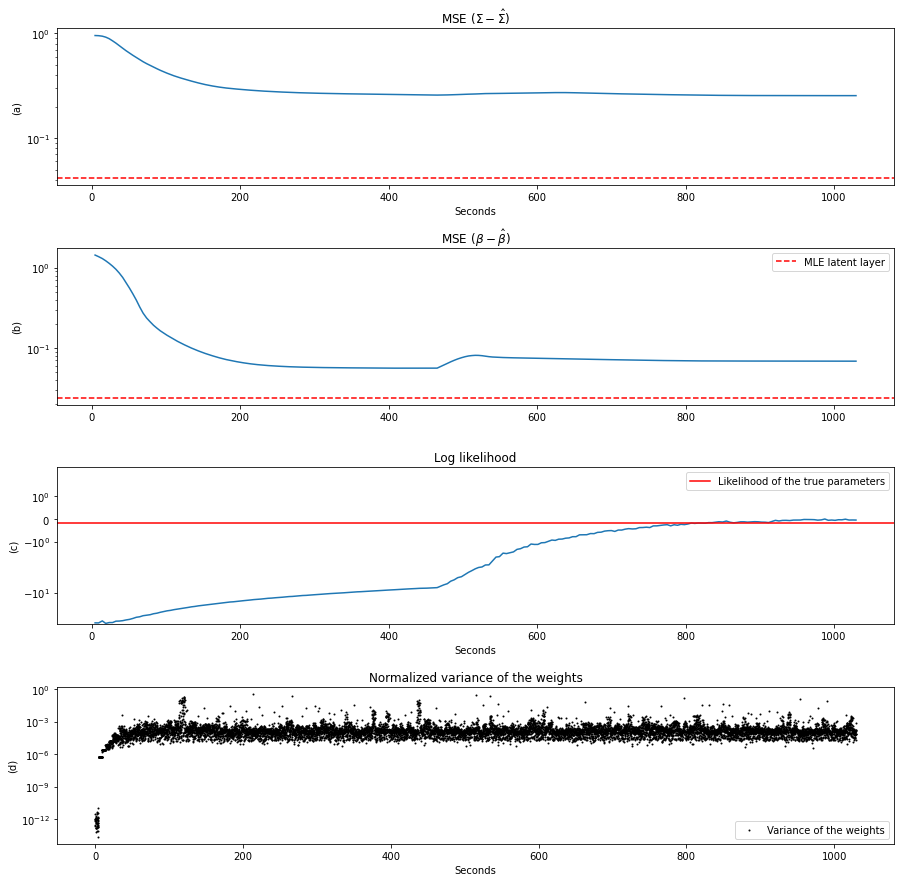

In [33]:
show(model, 'p=4, q= 3, logascent,acc=100', save = False)

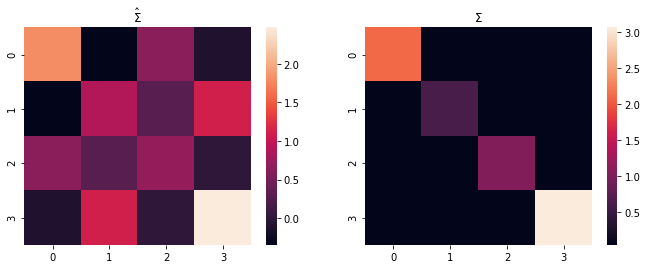

In [62]:
mat = model.C_mean.detach().numpy()

fig,axes = plt.subplots(1,2,figsize = (11.2,4))
axes[0].set_title(r'$\hat \Sigma$')
sns.heatmap(mat@(mat.T),ax = axes[0])
axes[1].set_title(r'$\Sigma$')
sns.heatmap(Sigma_sampling,ax = axes[1])
plt.savefig('result Sigma')

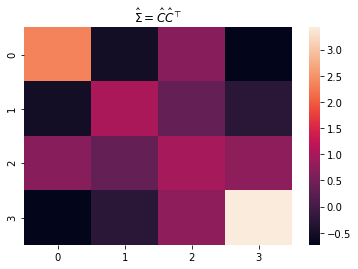

In [141]:
model.show_Sigma()
plt.title(r'$\hat \Sigma = \hat C \hat{C}^{\top}$')
plt.savefig('Sigma found')

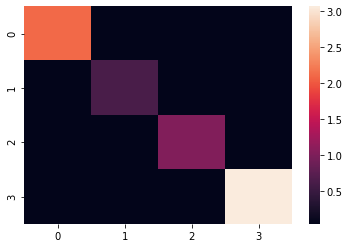

In [142]:
sns.heatmap(Sigma_sampling)
plt.savefig('True Sigma p=4,q=3')

In [16]:
d = 2
n = 100;  p = 4
q = 3

In [17]:
torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/2 #+ 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/1

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)

### $\Sigma$ MLE 

MLE :


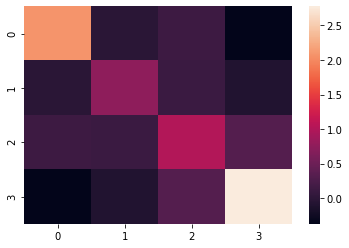

true Sigma


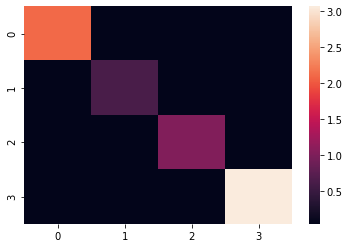

Best MSE we can have (in our dream):  tensor(0.0416)


In [18]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(Sigma_sampling.to(torch.device('cpu')))
plt.show()
best_MSE_Sigma = torch.mean((Sigma_MLE.to(device)-Sigma_sampling)**2)
print('Best MSE we can have (in our dream): ', best_MSE_Sigma)

### $\beta$ MLE

In [19]:
target = Z_sampled+ torch.mm(covariates,true_beta)

clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
best_MSE_beta = torch.mean((beta_dream-true_beta)**2)
print('MSE beta in the latent layer: ', best_MSE_beta)

MSE beta in the latent layer:  tensor(0.0240)


$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=\beta^{\top}\mathbf{x}_{i} +\mathbf{C}W_i , \quad i \in 1, \ldots, n \\
Y_{i j} \mid Z_{i j} & \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
\end{aligned}
$$

In [20]:
from fastPLN import fastPLN
fastmodel = fastPLN()
fastmodel.fit(Y_sampled,O,covariates, 50)
print('MSE Sigma', torch.mean((fastmodel.Sigma-Sigma_sampling)**2))
print('MSE beta', torch.mean((fastmodel.beta-true_beta)**2))

MSE Sigma tensor(0.0602, grad_fn=<MeanBackward0>)
MSE beta tensor(0.0357, grad_fn=<MeanBackward0>)


### First method : direct optimization of the likelihood

We want to maximize the likelihood with respect to $\theta$ : 


$$\max _{\theta} P_{\theta}(Y)$$

But we need to integrate out $W$ in order to compute the quantity inside the max : 

$$
\begin{aligned}
P_{\theta}\left(Y_{i}\right) &=\int P_{\theta}\left(Y_{i}, W\right) d W \\
&=\int P_{\theta}\left(Y_{i} \mid W\right) p(W) d W
\end{aligned}
$$

This integral being untractable, we are going to approximate it with Monte Carlo methods : 

$$
\int p_{\theta}\left(Y_{i} \mid W\right) p(W) d W \approx \frac{1}{K} \sum_{k = 1 }^Kp_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)
$$
$$W_{i,k} \sim \mathcal N (0, I_q)$$

The larger the $K$ the better the approximation.  

Let's compute $p_{\theta}\left(Y_{i} \mid W_i\right) p\left(W_i\right)$. 


First, 

$$
P\left(W_{i}\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2}\left\|W_{i}\right\|_{2}^{2}\right)
$$ 

Then, 

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{:,j}+ C_{j}^{\top}W_{i}
$$

Putting all together : 

$$
\begin{aligned}
p_{\theta}\left(Y_{i} \mid W_{i}\right) p\left(W_{i}\right) 
& =\operatorname{const} \times \exp \left(-\frac{1}{2} W_{i}^{\top} W_{i}\right) \exp \left(\sum_{j=1}^{p}-\operatorname{exp}\left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right)\right)\\
&= \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+Z_{i}\right)+Y_{i}^{\top}\left(0_{i}+Z_{i}\right)\right)\\
& = \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top}\left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)\right)\\
& = \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)\\
\end{aligned}
$$

We set $p^{(u)}_{\theta}(W_i) = \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)$

For numerical purposes, we may want to use a logarithmic scale and apply the exponential function after. Indeed, $Y_{ij}$ can go up to a thousand, and computing this factorial would give infinite values. 

$$
\log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\sum_{j=1}^{p} - \ln \left(Y_{i j} !\right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+Z_{i j}\right)
$$

We are going tu use the Stirling Formula in order to compute the log of the factorial, to avoid computing directly the factorial. 


If we consider the whole likelihood : 

$$
\begin{aligned}
\ln p_{\theta}\left(Y \mid W\right) &=\sum_{i=1}^{n} \log p_{\theta}\left(Y_{i} \mid W_{i}\right) \\
&=\sum_{i=1}^{n} \sum_{j} - \ln \left(Y_{ij} ! \right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right) \\
&=1_{n}^{T}\left[-\ln (Y !)-\exp (0+Z)+Y \odot (0+Z)\right] 1_{p} \\
Z=& X \beta+W C^{\top}
\end{aligned}
$$



We now need to compute the gradients. Since 

$$
\nabla_{\theta} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i}| W_{i}\right) \nabla_{\theta} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)
$$

### Gradient computation 


Let's compute $$
\nabla_{{\theta}} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)
$$


We begin with $\beta$. We see the vectors of size $n$ as a matrice of dimension $(n,1)$ ( a line).

We set $A=O+ CW_{i}$

We set 

$$
h: \beta \mapsto \mathbb{1}_{p}^{\top}\exp \left( \beta^{\top}X_{i}+A\right) 
$$

$$
\begin{aligned}
\frac{\partial h(\beta)}{\partial \beta_{k l}} &=\frac{\partial}{\partial \beta_{k l}}\left(\sum_j \exp \left(X_{i}^{\top}\beta_{:, j}+A_{j}\right)\right)\\
&=\frac{\partial}{\partial \beta_{k,l} } \exp \left(X_{i}^{\top} \beta_{:,l}+A_{l}\right) \\
&=\frac{\partial}{\partial \beta_{kl} } \exp \left(\sum_{s} X_{i s} B_{s l}+A_{l}\right)\\
&=\left(\frac{\partial}{\partial \beta_{k l}}\left(\sum_{s} x_{i s} \beta_{s l}+A_{l}\right)\right) \exp \left(\sum_{s} X_{i s} \beta_{sl}+A_l\right) \\
&=X_{i k} \exp \left(\sum_{s} X_{i s} \beta_{s l}+A_{l}\right)\\
&=X_{i k} \exp \left(X_{i}^{\top} \beta_{:,l}+A_{l}\right) \\
&=\left( X_{i}\exp \left( \beta^{\top}X_{i}+A\right) ^{T} \right) _{k 1}
\end{aligned}
$$

So that $$\nabla _{\beta} h =  X_i\exp \left(O_i +  \beta^{\top}X_{i}+  CW_{i,k}\right)^{\top}$$

A similar argument for $$
\tilde h: \beta \mapsto  \sum_{j} Y_{i j}\left(0_{ij}+X_{i}^{\top} \beta_{:,j}+W_{i} C^{\top}_{:,j}\right)
$$

shows that 

$$
\nabla_{\beta} \tilde{h}=X_{i} Y_{i}^{\top}
$$

So that : 
<span style="color:red"> 
$$
\boxed{
\nabla_{\beta} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)= \nabla _{\beta} \tilde h - \nabla _{\beta}  h= X_{i} \left[Y_i - \exp \left(O_i +  \beta^{\top} X_i+CW_{i}  \right) \right]^{\top}}
$$
</span>
A similar argument for $C$ shows that : 
<span style="color:red"> 
$$
\boxed{
\nabla_{C} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}}
$$
</span>

(Note that if you want to see the vectors as matrices of size (1,n), you only need to  transpose  each vector and it should work fine : 

If we see the vectors as matrices of size (1,n) : 
$$
\nabla_{C} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\left[Y_{i}- \exp \left(O_i + X_{i} \beta+W_{i}C^{\top}\right)\right]^{\top}  W_{i}
$$

The first vector has a size $(p,1)$, the second $(1,q)$, which makes it $(p,q)$.
)
    

We get : 

$$
\nabla_{\beta} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i} \mid W_{i}\right)
X_{i} \left[Y_i - \exp \left(O_i +  \beta^{\top} X_i+CW_{i}  \right) \right]^{\top}
$$
$$
\nabla_{C} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i} \mid W_{i}\right)
\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}
$$

##### After trying to optimize the likelihood, we have found that the likelihood is very small (the order of the log likelihood is about $-3\times10^{3}$ for some samples which makes the exponential 0 numerically. We need the likelihood to compute the gradients (see above). We can't optimize the log likelihood directly due to the integral : 


$$
\begin{aligned}
\log p_{\theta}(Y) &=\log \left(\int p_{\theta}(Y, W)dW\right) \\
& \approx \log \left(\frac{1}{K}\sum^K p_{\theta}\left(Y, W_{k}\right)\right)\\
& \neq \frac{1}{K} \sum^{K} \log \left(p_{\theta}\left(Y, W_{k}\right)\right)
\end{aligned}
$$

### Importance Sampling 

We thus change the objective function. We want to maximize the log likelihood with respect to $\theta$ : 


$$\max _{\theta}\operatorname{log} P_{\theta}(Y) = \max _{\theta} \sum _i \operatorname{log} p_{\theta}(Y_i)$$
 
 
We need to derive the gradients with respect to theta : 


$$
\begin{aligned}
\nabla_{\theta} \log p_{\theta}(Y_i)&= \frac{\nabla_{\theta} p_{\theta}(Y_i)}{p_{\theta}(Y_i)} \\
&=\frac{\nabla_{\theta} \int p_{\theta}(Y_i \mid W_i) p(W_i) d W}{\int p_{\theta}(Y_i \mid W_i) p(W_i) d W_i}\\
&=\frac{\int \nabla_{\theta} p_{\theta}(Y_i | W_i) p(W_i) d W_i}{\int  p_{\theta}(Y_i|W_i) p(W_i) d W_i}\\
&= \frac{\int\left(\nabla_{\theta} \ln p_{\theta}(Y \mid W)\right) p_{\theta}(Y| W) p(W) d W}{\int p_{\theta}(Y_i \mid W_i)p(W_i) d W_i}\\
&=\int \nabla_{\theta} \ln p_{\theta}(Y_i \mid W_i) \tilde{p}_{\theta}(W_i) dW_i \\
\end{aligned}
$$
$$\tilde p_{\theta}(W_i):=\frac{p_{\theta}(Y_i \mid W_i) p(W_i) d W_i}{\int p_{\theta}(Y_i \mid W_i) p(W_i) dW_i}$$


So that : 

<span style="color:red">
$$
\boxed{\nabla_{\theta} \log p_{\theta}(Y_i) = \mathbb E_{\tilde p } \left[\nabla_{\theta} \ln p_{\theta}(Y_i \mid W_i)\right]}$$ 
</span>

Here $\tilde p $ is the law of $W_i | Y_i$. Indeed : 

$$
\begin{aligned}
p_{\theta}(W_i \mid Y_i) &=\frac{p_{\theta}(Y_i|W_i) \operatorname{p}(W_i)}{p_{\theta}(Y_i)} \\
& = \frac {  {p_{\theta}}\left(Y_i \mid W_{i}\right)p(W_i)}{\int p_{\theta}(Y_i \mid W_i) p(W_i) dW_i}\\
&= \tilde p_{\theta}(W_i)
\end{aligned}
$$
Note also that 

$$\tilde p_{\theta}(W_i) = \frac{p^{(u)}_{\theta}(W_i)}{\int p^{(u)}_{\theta}(W_i) dW_i}$$

We only know the numerator of $ p^{(u)}_{\theta}(W)$. Thus we need to use importance sampling, which consits in the following : 

Let $\phi $ be a mesurable function. Let $g$ be a probability density such that $x \in \operatorname{supp}(\tilde p_{\theta}) \implies g(x)>0$. We denote $(V_{i,k})_k \overset{iid}{\sim} g$. 

We define : 

$$
w_{k}^{(u)}=\frac{p^{(u)}_{\theta}\left(V_{i,k}\right)}{g\left(V_{i,k}\right)}
$$


$$
\tilde{w}_{k}^{(u)}=\frac{w_{k}^{(u)}}{\sum_{\ell=1}^{n} w_{\ell}^{(u)}}
$$


Then, 

$$
\hat{I}_{n_{\text{samples}}}^{I S, u}:=\sum_{k=1}^{n_{\text{samples}}} \tilde{w}_{k}^{(u)} \phi (V_{i,k})
 \xrightarrow[n_s \to + \infty]{\mathbb P} \int \phi(W) \tilde p_{\theta}(W) = \mathbb E _{\tilde p _{\theta}}[\phi(W)]
$$

We need to choose carefully the density $g$ i.e. where $ p^{(u)}_{\theta}\times \nabla_{\theta} \log p_{\theta}$ has a lot of mass.

We start with $\beta$: 


$$
\begin{align*}
\nabla_{\beta} \log {p_{\theta}}(Y_i)&=E_{\tilde{p}_{\theta}}\left[\nabla _ { \beta } \operatorname {log}  p_{\theta} \left(Y_{i}\left|W_{i k}\right)\right]\right.\\
&=X_{i}\left[Y_{i}-\exp \left(0_{i}+ \beta^{\top} X_i\right) \mathbb E_{\tilde p_{\theta}}\left[e^{CW_{i,k} }\right]\right]^{\top}
\end{align*}
$$

Let's look closer at this integral. 

$$\mathbb E_{\tilde p_{\theta}}\left[e^{CW_{i,k}}\right] 
=\left(\begin{array}{l}
E_{\tilde{p}_{\theta}}\left[e^{\left(CW_{i,k}\right)_{1}}\right] \\
\quad \quad  \vdots \\
E_{\tilde p_{\theta}}\left[e^{\left(CW_{i,k}\right)_p}\right]
\end{array}\right)
=\left(E_{\tilde p_{\theta}}\left[e^{u_{m}^{\top}CW_{i} }\right]\right)_{1 \leqslant m\leqslant p}
$$


Where $u_m$ is the canonic vector (i.e. a vector full of zeros except $1$ on the $m$ position)

Let $ 1 \leq m \leq p$.Let $ \phi _{\beta,m}(W)=e^{u_{m}^{\top}CW_{i} } $  Let's look at $E_{\tilde p_{\theta}}\left[\phi _{\beta,m}(W)\right]$

$$
\begin{aligned}
(\star) = E_{\tilde p_{\theta}}\left[\phi _{\beta,m}(W) \right]  &= \int e^{u_{m}^{\top}CW_{i,k} } \frac {p_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)}{{\int p_{\theta}(Y_i,W)  dW}}dW_{i,k} = \int e^{u_{m}^{\top}CW_{i,k} } \frac {p^{(u)}_{\theta}(W_i)}{\int p^{(u)}_{\theta}(W_i) dW_i} \\
& =  \frac {1}{\int p^{(u)}_{\theta}(W) dW}\int  \exp \left(u_{m}^{\top}CW_{i,k}-\frac{1}{2}\left\|W_{ik}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i,k}\right)+Y_i^{\top}CW_{i,k}\right)d W_{i,k} \\
& =  \frac {1}{{\int p^{(u)}_{\theta}(W)  dW}}\int  \exp \left((u_{m}+Y_i)^{\top}CW_{i,k}-\frac{1}{2}\left\|W_{ik}\right\|^{2} -\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i,k}\right)\right)d W_{i,k}\\
\end{aligned}
$$


We set 
$$
\mu_{m}:=\left(u_{m}+Y_{i}\right)^{\top} C
$$

Let $(V_{i,k,m})_k  \overset{iid}\sim \mathcal N(\mu_{m}, I_q)$ ang $g_m$ the corresponding density. 

Then, $$ \begin {aligned}
g_m(V) & = \frac{1}{(2 \pi)^{q / 2}} \exp \left[-\frac{1}{2}(\boldsymbol{V}-\boldsymbol{\mu_m})^{\top} (\boldsymbol{V}-\boldsymbol{\mu_m})\right]\\
& = \frac{1}{(2 \pi)^{q / 2}} e^{-\frac{\mu_m ^{\top} \mu_m}{2}} e^{- \frac 1  2 V^{\top} V+V^{\top} \mu_m}
\end{aligned}
$$

We set $A(\mu_m) = \frac{1}{(2 \pi)^{q / 2}} e^{-\frac{\mu_m ^{\top} \mu_m}{2}}$






Let's compute the importance weights for $g$. 

$$
\begin{aligned}
w^{(u)}_k & = \frac{p^{(u)}_{\theta}\left(V_{i,k}\right)}{g\left(V_{i,k}\right)} \\
& = \frac { \exp \left(-\frac{1}{2}\left\|V_{i,k}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CV_{i,k}\right)+Y_{i}^{\top} CV_{i,k}\right)}{A(\mu _m ) e^{- \frac 1  2 V_{i,k}^{\top} V_{i,k}+V_{i,k}^{\top} \mu_m}} \\
& = \frac 1 {A(\mu _m)  } \operatorname{exp}\left(-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CV_{i,k}\right) - u_m^{\top}CV_{i,k}\right)
\end{aligned}
$$

Note that in practice, setting $\mu _m = 0$ works better. We will see why after. 


Computation for the gradient of $C$ : 

$$
\begin{align*}
\nabla_{C} \log {p_{\theta}}(Y_i)&=E_{\tilde{p}_{\theta}}\left[\nabla _ { C } \operatorname {log}  p_{\theta} \left(Y_{i}\left|W_{i k}\right)\right]\right.\\
&= \mathbb E_{\tilde p_{\theta}}\left[\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}\right]\\
&= Y_{i}\mathbb E_{\tilde p_{\theta}} \left[ W_i^{\top} \right] -\exp(O_i + \beta^{\top}X_i) \mathbb E_{\tilde p_{\theta}}\left[\exp \left(CW_{i}{ }\right)  W_{i}^{\top}\right]
\end{align*}
$$

Let's look closer at the integrals. 
$$
E_{\tilde p_{\theta}}\left[\exp \left(CW_{i}{ }\right)  W_{i}^{\top}\right] = (E_{\tilde p_{\theta}}\left[\exp \left(u_k^{\top} CW_{i}\right)  W_{i}^{\top}u_m\right])_{1 \leq k \leq p, 1 \leq m \leq q}
$$

$$\mathbb E_{\tilde p_{\theta}} \left[ W_i^{\top} \right] = \mathbb E_{\tilde p_{\theta}} \left[ W_i^{\top}u_m \right]_{1 \leq m \leq q}
$$

We only need to approximate these integrals and we can compute the gradients.



### Choosing the law g

We want to get a good law $g$ for importance sampling. 
We will try to modify the model so that the law inside the integral are computable and we hope it will help. 

We look at the following model : 

$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=O_i +  \beta^{\top}\mathbf{x}_{i} +\mathbf{C}W_i , \quad i \in 1, \ldots, n \\
\operatorname{log} (Y_{i}) \mid Z_{i} & \sim \mathcal{N}\left( Z_{i}, \operatorname{diag}(\exp(-|O_i +\beta ^{\top} X_i |)\right)
\end{aligned}
$$

We denote $D_i:= \operatorname{diag}(\exp(-|O_i +\beta ^{\top} X_i |)$.

Here are the heuristics for choosing this model. 
First, we approximate the Poisson law with a gaussian: 

$$\mathcal P (exp(Z_i)) \approx \mathcal N(\exp(Z_i), \operatorname{diag} (\exp(Z_i))$$ 



Now, with some computation ( see for example the end of the notebook) 

we can do this approximation : 

$$ \exp (\mathcal N (Z_i, \operatorname{diag}(\exp(-|Z_i|)) \approx \mathcal N (\exp(Z_i), \operatorname{diag}(\exp(Z_i))$$

For computation purposes and to have a law that is computable, we need to remove $CW$ from the variance term inside the absolute value(to get back a gaussian when computing the law of the latent variables given the observation), which gives the heuristic. 

After some computation, we find that given this model, we can compute the law $W_i|Y_i$ : 

$$W_i|Y_i \sim \mathcal N((\log(Y_i)-X_i\beta)^{\top}D^{-1}C, (C^{\top}D^{-1}C + I)^{-1})$$ 

The better $g$ we can take ( to approximate $\mathbb E _{p_{\theta}(W_i|Y_i)}\left[e^{ u_m^{\top}CW_i}\right]$ being the law  : $$g^{\star}(x) = e^{ u_m^{\top}Cx} p_{W_i|Y_i}(x) , x \in R^q$$

After some little computation we find that : 

$$ g^{\star}(x) = \mathcal N (x; (\log(Y_i)-X_i\beta)^{\top}D^{-1}C + u_m^{\top}C, (C^{\top}D^{-1}C + I)^{-1})$$

### Computation of the law of $W_i|Y_i$ for the modified model. 

We set $$\mu_i := \log(Y_i) -X_i\beta$$

Let's compute the law of the latent variables given the data.

\begin{aligned}
p_{\theta}\left(W_{i} \mid \log \left(Y_{i}\right) \right) & = p_{\theta}\left(\log \left(Y_{i}\right) \mid W_{i}\right) p\left(W_{i}\right) \\
& = C \times \exp \left(-\frac{1}{2}\left(\left(CW_{i}-\mu_{i}\right)^{T} D^{-1}\left(CW_{i}-\mu_{i}\right)+W_{i}^{\top} W_{i}\right)\right) \\
& C \times \exp \left(-\frac{1}{2}\left(W_{i}^{\top}C^{\top}D^{-1}CW_{i}-2\mu_{i}^{\top}D^{-1}CW_i+\mu_i^{\top}D^{-1}\mu_i+W_{i}^{\top} W_{i}\right)\right) \\
& = C \times \exp \left(-\frac{1}{2}\left(W_{i}^{\top}\left(C^{\top}D^{-1}C+ I_q\right)W_{i}\right)+\mu_{i}^{\top}D^{-1}CW_i\right)
\end{aligned}

By identification : 

$$W_i |\log(Y_i) \sim \mathcal N \left(C^{\top}D^{-1}\mu_i, (C^{\top}D^{-1}C+ I_q)^{-1} \right) $$

Then, 

$$ u_m^{\top}C W_i |\log(Y_i) \sim \mathcal N\left(u_m^{\top}CC^{\top}D^{-1}\mu_i, u_m^{\top}C(C^{\top}D^{-1}C+ I_q)^{-1}C^{\top}u_m \right)$$

sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$C :  (p,q)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

### some functions I tried, might be useful but not clean. 

In [23]:
def plot_2D(f,x_abscisse, y_abscisse):
    Z = np.zeros((len(x_abscisse), len(y_abscisse)))
    maxi = 0
    argmax = (0,0)
    def f_(x,y):
        return f(torch.tensor([x,y]))
    total_mass = scipy.integrate.dblquad(f_,-10,10,-10,10)[0]
    for i,x in enumerate(x_abscisse): 
        for j,y in enumerate(y_abscisse):
            xy_ten = torch.tensor([x,y])
            value = (f(xy_ten))
            if value > maxi : 
                argmax = (i,j)
                maxi = value
            Z[i,j]= value
            
    
    best_mean = torch.tensor([x_abscisse[argmax[0]],y_abscisse[argmax[1]]])
    def gauss_density(Z):
        Sig = (torch.diag(true_Sigma)**(-1))*torch.eye(2)
        inv_Sig = torch.inverse(torch.eye(2)/3)
        C = 2*math.pi*torch.sqrt(torch.det(Sig))
        return 1/C*torch.exp(- 1/2*torch.matmul(torch.matmul(Z-best_mean, inv_Sig), (Z-best_mean).T).squeeze())
    
    gauss = np.zeros((len(x_abscisse), len(y_abscisse)))
    for i,x in enumerate(x_abscisse): 
        for j,y in enumerate(y_abscisse):
            xy_ten = torch.tensor([x,y])
            gauss[i,j] = gauss_density(xy_ten)
            
            
    fig = plt.figure(figsize = (19.5,9.5))
    ax = fig.add_subplot(1,2,1, projection='3d')
    X,Y = np.meshgrid(x_abscisse,y_abscisse)
    ax.plot_surface(X, Y, (Z/total_mass).T, cmap = cm.coolwarm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Posterior distribution', fontsize = 15)
    
    ax_bis = fig.add_subplot(1,2,2, projection='3d')
    ax_bis.set_xlabel('x')
    ax_bis.set_ylabel('y')
    ax_bis.set_zlabel('z')
    ax_bis.set_title('Gaussian approximation distribution', fontsize = 15)

    ax_bis.plot_surface(X, Y, gauss.T, cmap = cm.coolwarm)
    plt.show()
    #fig.savefig('Comparison distribution')
    return Z,  
    

    
def f_expmoment(Z): 
    return torch.exp(torch.sum(Z))*p(Z)

def Z_density(Z,i):
    XB = torch.matmul(covariates[i].unsqueeze(0),true_beta)
    
    log_ = torch.sum(-torch.exp(Z) + Y_sampled[i,:]*Z) - 1/2*torch.matmul(torch.matmul(Z-XB, torch.inverse(true_Sigma)), (Z-XB).T).squeeze()
    return torch.exp(log_)                                               
#plot = plot_2D(Z_density, np.linspace(-1,4,100),np.linspace(-3,2,100))

$$
\begin{aligned}
p_{\theta}(Z_i \mid Y_i )  & = \frac{p_{\theta}\left(Y_{i} \mid Z_{i}\right) p\left(Z_{i}\right)}{p_{\theta}(Y_i)} \\
& \propto  ~ p_{\theta}\left(Y_{i} \mid Z_{i}\right) p\left(Z_{i}\right) \\
& \propto ~ \exp \left(   \sum_{j=1}^{p}-\operatorname{exp}\left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right)   -\frac{1}{2} (Z_{i}-\beta^{\top}X_i)^{\top} \Sigma ^{-1} (Z_{i}-\beta^{\top}X_i) \right) \\
\end{aligned}
$$


In [24]:
def plot_1D(f,i,j, abscisse_first, abscisse_second): 
    values_first  = list()
    values_second = list()
    def f_first(x): 
        return f(torch.tensor([x]), i ) 
    def f_second(x): 
        return f(torch.tensor([x]), j )
    total_mass_first = scipy.integrate.quad(f_first,-10,10)[0]
    total_mass_second = scipy.integrate.quad(f_second, -10,10)[0]
    
    
    for w_first, w_second in zip(abscisse_first, abscisse_second) : 
        values_first.append(np.squeeze((f_first(w_first)).numpy())/total_mass_first)
        values_second.append(np.squeeze((f_second(w_second)).numpy())/total_mass_second)
    values_first = np.array(values_first)
    values_second = np.array(values_second)
    
    argmax_first = abscisse_first[np.argmax(values_first)]
    argmax_second = abscisse_second[np.argmax(values_second)]
    gauss_first = []
    gauss_second = []
    sig_first = 0.1
    sig_second = 0.6
    def gauss_density(w, sig,argmax): 
        return 1/math.sqrt(2*math.pi*sig**2)*np.exp(-1/(2*sig**2)*(w-argmax)**2)
    
    for w_first, w_second in zip(abscisse_first, abscisse_second) :
        gauss_first.append(gauss_density(w_first,sig_first, argmax_first))
        gauss_second.append(gauss_density(w_second,sig_second, argmax_second))
        
    gauss_first = np.array(gauss_first)
    gauss_second = np.array(gauss_second)
    
    
    #gauss_first*= np.max(values_first)/np.max(gauss_first)
    #gauss_second*= np.max(values_second)/np.max(gauss_second)*1.03
    fig, axes = plt.subplots(1,2, figsize = (20,10))
    axes[0].plot(abscisse_first, gauss_first, label = 'gaussian approximation')
    axes[0].plot(abscisse_first,np.abs(values_first), label = 'Posterior distribution')
    axes[0].legend()
    axes[1].plot(abscisse_second, gauss_second, label = 'gaussian approximation')
    axes[1].plot(abscisse_second,np.abs(values_second), label = 'Posterior distribution')
    axes[1].legend()
    plt.show()
    fig.savefig('Comparison 1D')
    return argmax_first,argmax_second

In [25]:
plot_2D(lambda x,y: x*y ,abscisse,torch.linspace(-5,5,100))

NameError: name 'abscisse' is not defined

In [ ]:
plot_1D(Z_density,13,28, np.linspace(0,8,200), np.linspace(-4,4,200))

This is if we take only one sample $Y_i$. If we take the whole dataset (or a mini-batch), we get (writed in matrix form) :

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$